## Steps
1. Camera Calibration
2. Distortion Correction
3. Color and Gradient Threshold
4. Perspective Transform
5. Detect Lane Lines
6. Determine Lane Curvature
7. Impose Lane Boundaries on Original Image
8. Pipeline

In [122]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob2
from moviepy.editor import VideoFileClip
import math
from collections import deque
#%matplotlib qt  
%matplotlib inline



### 1. Camera Calibration

In [2]:

def calibrate_camera(images, nx, ny, display=True):
    objpoints = []
    imgpoints = []
    
    ## object points
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    img_size = None
    # Make a list of calibration images
    plt.figure(figsize = (15,10))
   
    for i, im in enumerate(images ):
        img = cv2.imread(im)
        #print('Finding chessboard corners on {}'.format(im))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = gray.shape[::-1]
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        if ( display ):
            plt.subplot(4,5,i+1)
            plt.axis('off')
            plt.imshow(img)
        
    if (len(objpoints) == 0 or len(imgpoints) == 0):
        print( "Calibration Failed" )
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        
    return mtx, dist



In [4]:
def undistort(image, mtx, dist):
    image = cv2.undistort(image, mtx, dist, None, mtx)
    return image

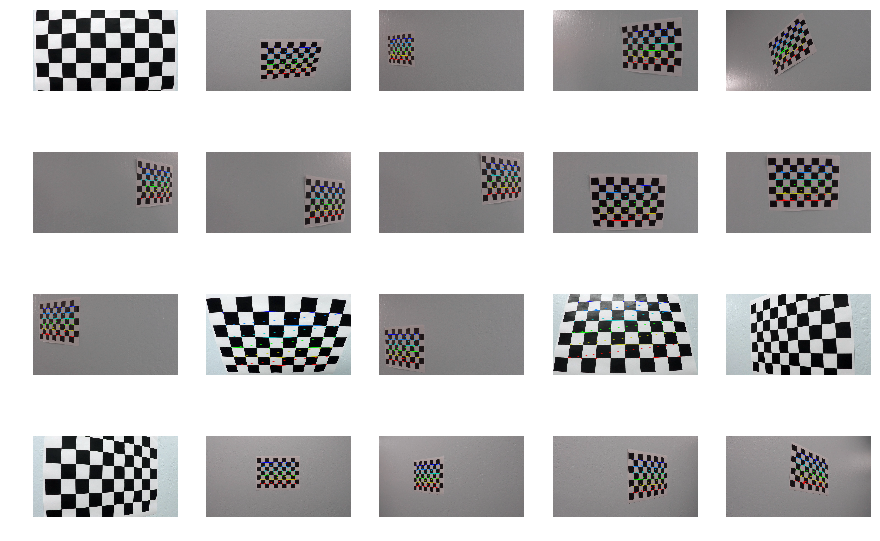

In [3]:
cal_dir = './camera_cal/'
cal_file = cal_dir+'calibration'
calibration_images = glob2.glob(cal_file+'*'+'.jpg')
mtx, dist = calibrate_camera(calibration_images, 9, 6)



### 2. Distortion Correction

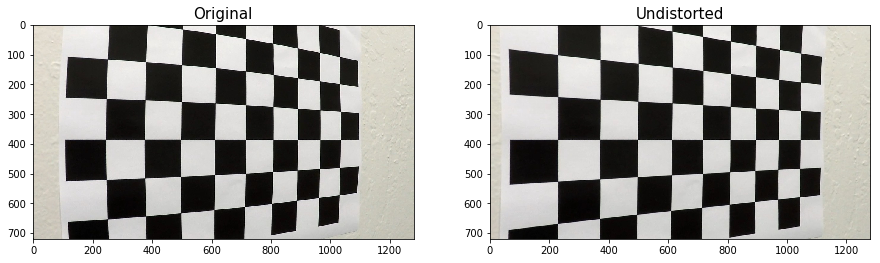

In [5]:
test_img = mpimg.imread("./camera_cal/calibration5.jpg")
undist_img = undistort(test_img, mtx, dist)
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title('Original', fontsize=15)
plt.subplot(1,2,2)
plt.imshow(undist_img)
plt.title('Undistorted', fontsize=15)

### 3. Color and Gradient Threshold

In [61]:
def convert_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls

def convert_hsv(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return hsv

def convert_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray

def apply_gaussian_blur(img, kernel=5):
    # Function to smooth image
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

def get_mask( t_img, thresh):
    mask = np.zeros_like(t_img)
    mask[(t_img >= thresh[0]) & (t_img <= thresh[1]) ] = 1
    return mask
    
# Calculate directional gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    ## img to gray
    gray = convert_gray(img)
    # Apply threshold
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray,cv2.CV_64F, 0, 1,ksize = sobel_kernel)
    
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255*sobel_abs/np.max(sobel_abs))

    return get_mask(sobel_scaled, thresh)

# Calculate gradient magnitude
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    ## img to gray
    
    gray = convert_gray(img)
    #print(gray.shape)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobelxy = np.sqrt((np.power(sobelx,2)+np.power(sobely,2)) )
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    return get_mask(scaled_sobel, thresh)

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = convert_gray(img)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    return get_mask(absgraddir, thresh)


def sobel_combined(image):
    # Combine sobel masks.
    img_g_mag = mag_thresh(image,15,(50,250))
    img_d_mag = dir_threshold(image,15,(.7,1.2))
    img_abs_x = abs_sobel_thresh(image,'x',15,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',15,(50,200))
    
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[ ( (img_abs_x == 1) | (img_abs_y==1 ) | (img_g_mag == 1) ) & ( img_d_mag == 1)] = 1
    return sobel_combined


def color_threshold(img):
    hsv = convert_hsv(img)
    
    ## Yellow lane
    yellow_min = np.array([15, 100, 100], np.uint8)
    yellow_max = np.array([100, 255, 255], np.uint8)
    yellow_mask = cv2.inRange(hsv, yellow_min, yellow_max)
    ## white lane
    sensitivity = 15
    white_min = np.array([0, 0,200 ], np.uint8)
    white_max = np.array([255, 80, 255], np.uint8)
    white_mask = cv2.inRange(hsv, white_min, white_max)
    
    
    ## HLS channels
    hls = convert_hls(img)
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    s_thresh = (90, 255)
    h_thresh = (15, 100)
    
    s_mask = get_mask(s_channel, s_thresh)
    h_mask = get_mask(h_channel, h_thresh)

    ## RGB channels
    r_channel = img[:,:,2]
    r_thesh = (200, 255)
    r_mask = get_mask(r_channel, r_thesh)
    
    color_mask =  s_mask | h_mask | r_mask
    combined_mask = np.zeros_like(color_mask)
    combined_mask[(( (yellow_mask != 0 ) | (white_mask != 0) ) & ( color_mask==1) ) ] = 1
        
    return combined_mask


### 4.Prespective Transform

In [123]:
def apply_perspective_transform(image):
    img_size = (image.shape[1], image.shape[0] )
    
    src = np.float32([
            [580, 460],
            [700, 460],
            [1040, 680],
            [260, 680],])

    dst = np.float32([
            [260, 0],
            [1040, 0],
            [1040, 720],
            [260, 720],])
    #src =  np.float32([[250,700],[1200,700],[550,450],[750,450]])
    # = np.float32([[250,700],[1200,700],[300,50],[1000,50]])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size)
    return warped


def apply_reverse_prespective_transform(image):
    img_size = (image.shape[1], image.shape[0] )
    
    src = np.float32([
            [580, 460],
            [700, 460],
            [1040, 680],
            [260, 680],])

    dst = np.float32([
            [260, 0],
            [1040, 0],
            [1040, 720],
            [260, 720],])
    #src =  np.float32([[250,700],[1200,700],[550,450],[750,450]])
    #dst = np.float32([[250,700],[1200,700],[300,50],[1000,50]])

    M_inverse = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M_inverse, img_size)
    return warped


### 5.Detect Lane Lines

In [218]:

def fit_line( x, y, degree=2 ):
    fit = None
    if( len(x) >0 and len(y) >0 ) :
        fit = np.polyfit(y, x, 2)
    
    return fit

def detect_lines_sliding_window(img, previous_lines, prev_count):
    
    if ( previous_lines and prev_count < 5 ):
        ## use previous frames for finding lines
        return detect_lines_regress(img, previous_lines)
    
    histogram = np.sum(img[int(img.shape[0] / 2):, :], axis=0)
    out_img = np.dstack((img, img, img)) * 255
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(img.shape[0] / nwindows)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return  (leftx, lefty), (rightx, righty)


def detect_lines_regress( image,previous_lines ):
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 140
    
    left_fit = previous_lines[-1][2]
    right_fit = previous_lines[-1][3]
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return  (leftx, lefty), (rightx, righty) 
   





def get_average_coefficients( l_fit, r_fit, previous_lines, prev_count ):
    prev_l_fit = previous_lines[-1][2]
    prev_r_fit = previous_lines[-1][3]
    err_R = 1.
    err_L = 1.
     ## Check error between current coefficient and on from previous frame
    if l_fit is not None and r_fit is not None: 
        err_R = np.sqrt( np.sum((r_fit[0]-prev_r_fit[0])**2) ) 
        err_L = np.sqrt( np.sum((l_fit[0]-prev_l_fit[0])**2) )
        
    if ( prev_count >= 5 ):
        return (l_fit, r_fit)
    if err_R >.0005:
        print('Warning: Right Coefficient Error - {}'.format(err_R))
        r_fit = prev_r_fit
        prev_count +=1
    else:
        r_fit = .05*r_fit+.95*prev_r_fit
        
    if err_L>.0005:
        print('Warning: Left Coefficient Error - {}'.format(err_L))
        l_fit = prev_l_fit
        prev_count +=1
    else:
        l_fit = .05*l_fit+.95*prev_l_fit
    
    return (l_fit, r_fit)

### 6. Determine Lane Curvature

In [213]:
def measure_curvature(img,  left_fit, right_fit):
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    y_eval = np.max(ploty)
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    ## change to real world vals
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    ratio = left_curverad / right_curverad
    if ratio < 0.66 or ratio > 1.5:
        print('Warning: shitty ratio {}'.format(ratio))

    lane_leftx = left_fit[0] * (img.shape[0] - 1) ** 2 + left_fit[1] * (img.shape[0] - 1) + left_fit[2]
    lane_rightx = right_fit[0] * (img.shape[0] - 1) ** 2 + right_fit[1] * (img.shape[0] - 1) + right_fit[2]

    car_pos = ((img.shape[1] / 2) - ((lane_leftx + lane_rightx) / 2)) * xm_per_pix 

    return (left_curverad + right_curverad) / 2, car_pos.round(2)
    
    

### 7.Impose Lane Boundaries on Original Image

In [180]:
def draw_poly( img, left_fit, right_fit):
    color_warp = np.zeros_like(img).astype(np.uint8)
    fity = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
    right_fitx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, fity])))])
    pts = np.hstack((pts_left, pts_right))
    pts = np.array(pts, dtype=np.int32)

    cv2.fillPoly(color_warp, pts, (0, 255, 0))
    
    newwarp = apply_reverse_prespective_transform(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    return result


### 8.Pipeline

In [245]:
def pipeline(image, mtx, dist, previous_lines, prev_count):
    ## global variables
    img_size = (image.shape[1], image.shape[0])
    
    ## undistort image
    image_undis =  undistort(image, mtx, dist)
    
    ## apply gaussian blur
    image_g = apply_gaussian_blur(image_undis)
    ## prespective transform 
    image_trans = apply_perspective_transform(image_g)
    
    ##apply sobel 
    sobel_mask = sobel_combined(image_trans)
    ## color threshold
    color_mask = color_threshold(image_trans)
    
    ## combined 
    mask = np.zeros_like(sobel_mask).astype(np.uint8)
    mask[((sobel_mask== 1) | ( color_mask==1) )] = 1
   
    ##lanes
    left_points, right_points = None,None
    l_fit, r_fit = None,None
   
    left_points, right_points = detect_lines_sliding_window(mask, previous_lines, prev_count)
    l_fit = fit_line(left_points[0], left_points[1])
    r_fit = fit_line(right_points[0], right_points[1])
     
    ### Visualization code
    '''ploty = np.linspace(0, mask.shape[0]-1, mask.shape[0] )
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    out_img = np.dstack((mask, mask, mask))*255
    window_img = np.zeros_like(out_img)
    nonzero = mask.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Color in left and right line pixels
    out_img[left_points[1], left_points[0]] = [255, 0, 0]
    out_img[right_points[1], right_points[0]] = [0, 0, 255]
  
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return'''
    #-------------------------
    ## if first frame -- add that as the previous frame
    if  not previous_lines : 
        previous_lines.append((left_points, right_points, l_fit, r_fit))
    
    ## do sanity check & get coordinates averaged
    l_fit, r_fit = get_average_coefficients( l_fit, r_fit, previous_lines, prev_count )
    ## add this to history
    previous_lines.append((left_points, right_points, l_fit, r_fit))
    
    #print( l_fit, r_fit)
    res = draw_poly(image_undis, l_fit, r_fit)    
    
    lane_curve, car_pos = measure_curvature(image_undis, l_fit, r_fit)

    ## get curves
    if car_pos > 0:
        car_pos_text = '{0:.2f}m right of center'.format(car_pos)
    else:
        car_pos_text = '{0:.2f}m left of center'.format(abs(car_pos))

    cv2.putText(res, "Lane curve: {}m".format(lane_curve.round()), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1,
                color=(255, 255, 255), thickness=2)
    cv2.putText(res, "Car is {}".format(car_pos_text), (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                color=(255, 255, 255),thickness=2)
    
    
  
    return res

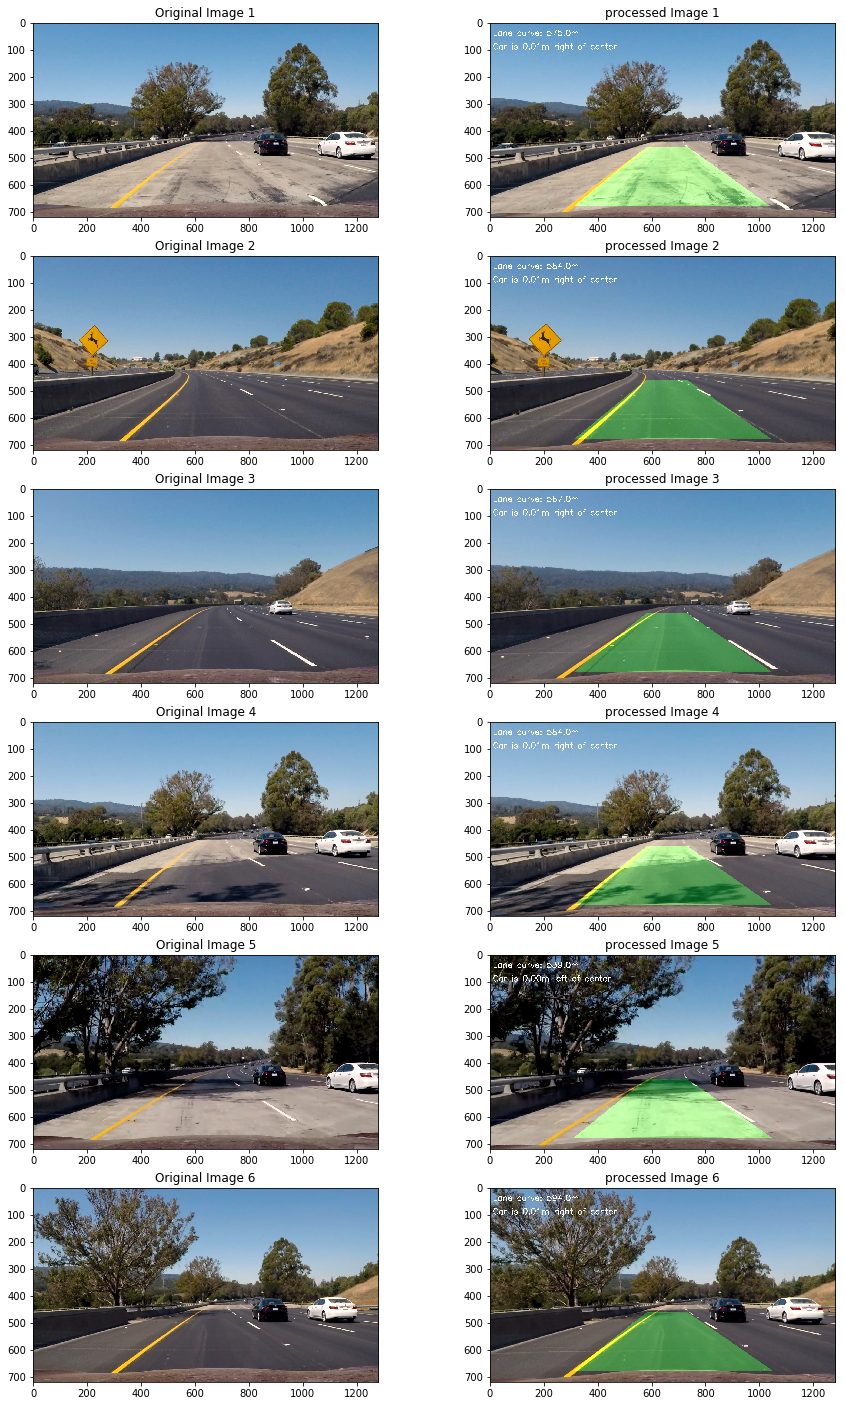

In [247]:
## test code 

plt.figure(figsize=(15, 25))
c = 1
previous_lines = deque(maxlen=3)
for i in range(6):
    num = i+1

    img = mpimg.imread("./test_images/test"+str(num)+".jpg")
    plt.subplot(6, 2,c)
    plt.imshow(img)
    plt.title("Original Image "+str(num))
    c += 1
    plt.subplot(6, 2,c)
    c += 1
    processed = pipeline(img, mtx, dist, previous_lines, 0)
    plt.imshow(processed)
    plt.title("processed Image "+str(num))
    


In [217]:

# Video writer
input_file = "./harder_challenge_video.mp4"
output_file = './ha'
clip1 = VideoFileClip(input_file)
previous_lines = deque(maxlen=3)
prev_count = 0
clip = clip1.fl_image(lambda img : pipeline( img, mtx, dist, previous_lines, prev_count) ) 
%time clip.write_videofile(output_file, audio=False)



[MoviePy] >>>> Building video ./harder_challenge_video_out.mp4
[MoviePy] Writing video ./harder_challenge_video_out.mp4


  3%|▎         | 40/1200 [00:15<07:11,  2.69it/s]

  4%|▍         | 48/1200 [00:18<07:10,  2.68it/s]

  4%|▍         | 49/1200 [00:18<07:10,  2.67it/s]

  5%|▌         | 63/1200 [00:23<07:05,  2.67it/s]

  5%|▌         | 64/1200 [00:24<07:08,  2.65it/s]

  6%|▌         | 69/1200 [00:26<07:03,  2.67it/s]

  6%|▌         | 70/1200 [00:26<07:02,  2.67it/s]

  6%|▌         | 71/1200 [00:26<07:06,  2.65it/s]

  6%|▌         | 72/1200 [00:27<07:11,  2.61it/s]

  6%|▌         | 73/1200 [00:27<07:10,  2.62it/s]

  6%|▋         | 75/1200 [00:28<07:09,  2.62it/s]

  6%|▋         | 76/1200 [00:28<07:09,  2.62it/s]

  6%|▋         | 77/1200 [00:29<07:04,  2.65it/s]

  6%|▋         | 78/1200 [00:29<07:03,  2.65it/s]

  7%|▋         | 79/1200 [00:29<07:03,  2.65it/s]

  7%|▋         | 80/1200 [00:30<07:06,  2.63it/s]

  7%|▋         | 81/1200 [00:30<07:06,  2.62it/s]

  7%|▋         | 82/1200 [00:30<07:09,  2.60it/s]

  7%|▋         | 83/1200 [00:31<07:08,  2.61it/s]

  7%|▋         | 84/1200 [00:31<07:10,  2.59it/s]

  7%|▋         | 85/1200 [00:32<07:11,  2.58it/s]

  7%|▋         | 86/1200 [00:32<07:05,  2.62it/s]

  7%|▋         | 87/1200 [00:32<07:06,  2.61it/s]

  7%|▋         | 88/1200 [00:33<07:03,  2.63it/s]

  7%|▋         | 89/1200 [00:33<07:00,  2.64it/s]

  8%|▊         | 90/1200 [00:34<07:00,  2.64it/s]

  8%|▊         | 91/1200 [00:34<06:55,  2.67it/s]

  8%|▊         | 92/1200 [00:34<06:58,  2.65it/s]

  8%|▊         | 93/1200 [00:35<06:57,  2.65it/s]

  8%|▊         | 94/1200 [00:35<06:57,  2.65it/s]

  8%|▊         | 95/1200 [00:35<06:57,  2.65it/s]

  8%|▊         | 96/1200 [00:36<06:54,  2.67it/s]

  8%|▊         | 97/1200 [00:36<06:53,  2.67it/s]

  8%|▊         | 98/1200 [00:37<06:51,  2.68it/s]

  8%|▊         | 99/1200 [00:37<06:55,  2.65it/s]

  8%|▊         | 100/1200 [00:37<06:52,  2.67it/s]

  8%|▊         | 101/1200 [00:38<06:48,  2.69it/s]

  8%|▊         | 102/1200 [00:38<06:46,  2.70it/s]

  9%|▊         | 103/1200 [00:38<06:46,  2.70it/s]

  9%|▊         | 104/1200 [00:39<06:43,  2.72it/s]

  9%|▉         | 105/1200 [00:39<06:40,  2.74it/s]

  9%|▉         | 106/1200 [00:39<06:37,  2.75it/s]

  9%|▉         | 107/1200 [00:40<06:37,  2.75it/s]

  9%|▉         | 108/1200 [00:40<06:40,  2.73it/s]

  9%|▉         | 109/1200 [00:41<06:38,  2.73it/s]

  9%|▉         | 110/1200 [00:41<06:35,  2.75it/s]

  9%|▉         | 111/1200 [00:41<06:35,  2.75it/s]

  9%|▉         | 112/1200 [00:42<06:35,  2.75it/s]

  9%|▉         | 113/1200 [00:42<06:39,  2.72it/s]

 10%|▉         | 114/1200 [00:42<06:38,  2.73it/s]

 10%|▉         | 115/1200 [00:43<06:33,  2.75it/s]

 10%|▉         | 116/1200 [00:43<06:32,  2.76it/s]

 10%|▉         | 117/1200 [00:43<06:34,  2.74it/s]

 10%|▉         | 118/1200 [00:44<06:34,  2.74it/s]

 10%|▉         | 119/1200 [00:44<06:32,  2.75it/s]

 10%|█         | 120/1200 [00:45<06:30,  2.76it/s]

 10%|█         | 121/1200 [00:45<06:31,  2.76it/s]

 10%|█         | 122/1200 [00:45<06:29,  2.76it/s]

 10%|█         | 123/1200 [00:46<06:31,  2.75it/s]

 10%|█         | 124/1200 [00:46<06:33,  2.73it/s]

 10%|█         | 125/1200 [00:46<06:34,  2.73it/s]

 10%|█         | 126/1200 [00:47<06:57,  2.57it/s]

 11%|█         | 127/1200 [00:47<07:27,  2.40it/s]

 11%|█         | 128/1200 [00:48<07:19,  2.44it/s]

 11%|█         | 129/1200 [00:48<07:51,  2.27it/s]

 11%|█         | 130/1200 [00:49<07:46,  2.29it/s]

 11%|█         | 131/1200 [00:49<07:26,  2.39it/s]

 11%|█         | 132/1200 [00:49<07:07,  2.50it/s]

 11%|█         | 133/1200 [00:50<07:19,  2.43it/s]

 11%|█         | 134/1200 [00:50<07:04,  2.51it/s]

 11%|█▏        | 135/1200 [00:51<06:53,  2.58it/s]

 11%|█▏        | 136/1200 [00:51<06:50,  2.59it/s]

 11%|█▏        | 137/1200 [00:51<06:41,  2.65it/s]

 12%|█▏        | 138/1200 [00:52<06:56,  2.55it/s]

 12%|█▏        | 139/1200 [00:52<07:10,  2.47it/s]

 12%|█▏        | 140/1200 [00:53<07:20,  2.41it/s]

 12%|█▏        | 141/1200 [00:53<07:21,  2.40it/s]

 12%|█▏        | 142/1200 [00:53<07:32,  2.34it/s]

 12%|█▏        | 143/1200 [00:54<07:11,  2.45it/s]

 12%|█▏        | 144/1200 [00:54<07:02,  2.50it/s]

 12%|█▏        | 145/1200 [00:55<07:11,  2.44it/s]

 12%|█▏        | 146/1200 [00:55<07:00,  2.50it/s]

 12%|█▏        | 147/1200 [00:55<06:47,  2.58it/s]

 12%|█▏        | 148/1200 [00:56<06:38,  2.64it/s]

 12%|█▏        | 149/1200 [00:56<06:29,  2.70it/s]

 12%|█▎        | 150/1200 [00:56<06:26,  2.71it/s]

 13%|█▎        | 151/1200 [00:57<06:22,  2.74it/s]

 13%|█▎        | 152/1200 [00:57<06:17,  2.77it/s]

 13%|█▎        | 153/1200 [00:58<06:25,  2.72it/s]

 13%|█▎        | 154/1200 [00:58<06:17,  2.77it/s]

 13%|█▎        | 155/1200 [00:58<06:13,  2.80it/s]

 13%|█▎        | 156/1200 [00:59<06:12,  2.80it/s]

 13%|█▎        | 157/1200 [00:59<06:07,  2.84it/s]

 13%|█▎        | 158/1200 [00:59<06:08,  2.83it/s]

 13%|█▎        | 159/1200 [01:00<06:10,  2.81it/s]

 13%|█▎        | 160/1200 [01:00<06:09,  2.82it/s]

 13%|█▎        | 161/1200 [01:00<06:04,  2.85it/s]

 14%|█▎        | 162/1200 [01:01<06:02,  2.86it/s]

 14%|█▎        | 163/1200 [01:01<05:59,  2.88it/s]

 14%|█▎        | 164/1200 [01:01<06:00,  2.87it/s]

 14%|█▍        | 165/1200 [01:02<05:58,  2.89it/s]

 14%|█▍        | 166/1200 [01:02<05:56,  2.90it/s]

 14%|█▍        | 167/1200 [01:02<06:05,  2.83it/s]

 14%|█▍        | 168/1200 [01:03<06:04,  2.83it/s]

 14%|█▍        | 169/1200 [01:03<06:04,  2.83it/s]

 14%|█▍        | 170/1200 [01:03<06:00,  2.85it/s]

 14%|█▍        | 171/1200 [01:04<06:01,  2.85it/s]

 14%|█▍        | 172/1200 [01:04<06:00,  2.85it/s]

 14%|█▍        | 173/1200 [01:05<06:00,  2.85it/s]

 14%|█▍        | 174/1200 [01:05<05:58,  2.86it/s]

 15%|█▍        | 175/1200 [01:05<05:58,  2.86it/s]

 15%|█▍        | 176/1200 [01:06<05:58,  2.86it/s]

 15%|█▍        | 177/1200 [01:06<05:55,  2.88it/s]

 15%|█▍        | 178/1200 [01:06<06:09,  2.77it/s]

 15%|█▍        | 179/1200 [01:07<06:29,  2.62it/s]

 15%|█▌        | 180/1200 [01:07<06:35,  2.58it/s]

 15%|█▌        | 181/1200 [01:08<06:41,  2.54it/s]

 15%|█▌        | 182/1200 [01:08<06:43,  2.53it/s]

 15%|█▌        | 183/1200 [01:08<06:45,  2.51it/s]

 15%|█▌        | 184/1200 [01:09<06:39,  2.54it/s]

 15%|█▌        | 185/1200 [01:09<06:26,  2.63it/s]

 16%|█▌        | 186/1200 [01:09<06:24,  2.64it/s]

 16%|█▌        | 187/1200 [01:10<06:16,  2.69it/s]

 16%|█▌        | 188/1200 [01:10<06:15,  2.70it/s]

 16%|█▌        | 189/1200 [01:11<06:38,  2.54it/s]

 16%|█▌        | 190/1200 [01:11<06:29,  2.60it/s]

 16%|█▌        | 191/1200 [01:11<06:19,  2.66it/s]

 16%|█▌        | 192/1200 [01:12<06:14,  2.69it/s]

 16%|█▌        | 193/1200 [01:12<06:33,  2.56it/s]

 16%|█▌        | 194/1200 [01:13<06:48,  2.46it/s]

 16%|█▋        | 195/1200 [01:13<06:49,  2.46it/s]

 16%|█▋        | 196/1200 [01:13<06:40,  2.50it/s]

 16%|█▋        | 197/1200 [01:14<06:57,  2.40it/s]

 16%|█▋        | 198/1200 [01:14<06:39,  2.51it/s]

 17%|█▋        | 199/1200 [01:15<06:32,  2.55it/s]

 17%|█▋        | 200/1200 [01:15<06:22,  2.62it/s]

 17%|█▋        | 201/1200 [01:15<06:46,  2.46it/s]

 17%|█▋        | 202/1200 [01:16<07:03,  2.35it/s]

 17%|█▋        | 203/1200 [01:16<07:11,  2.31it/s]

 17%|█▋        | 204/1200 [01:17<06:50,  2.43it/s]

 17%|█▋        | 205/1200 [01:17<07:05,  2.34it/s]

 17%|█▋        | 206/1200 [01:18<07:25,  2.23it/s]

 17%|█▋        | 207/1200 [01:18<07:31,  2.20it/s]

 17%|█▋        | 208/1200 [01:19<07:27,  2.22it/s]

 17%|█▋        | 209/1200 [01:19<07:34,  2.18it/s]

 18%|█▊        | 210/1200 [01:20<08:08,  2.02it/s]

 18%|█▊        | 211/1200 [01:20<07:44,  2.13it/s]

 18%|█▊        | 212/1200 [01:20<07:42,  2.14it/s]

 18%|█▊        | 213/1200 [01:21<07:31,  2.18it/s]

 18%|█▊        | 214/1200 [01:22<08:06,  2.03it/s]

 18%|█▊        | 215/1200 [01:22<08:40,  1.89it/s]

 18%|█▊        | 216/1200 [01:23<08:30,  1.93it/s]

 18%|█▊        | 217/1200 [01:23<07:57,  2.06it/s]

 18%|█▊        | 218/1200 [01:23<07:46,  2.10it/s]

 18%|█▊        | 219/1200 [01:24<07:57,  2.05it/s]

 18%|█▊        | 220/1200 [01:24<07:29,  2.18it/s]

 18%|█▊        | 221/1200 [01:25<07:16,  2.24it/s]

 18%|█▊        | 222/1200 [01:25<07:41,  2.12it/s]

 19%|█▊        | 224/1200 [01:26<07:01,  2.32it/s]

 19%|█▉        | 225/1200 [01:27<06:52,  2.36it/s]

 19%|█▉        | 226/1200 [01:27<06:39,  2.44it/s]

 19%|█▉        | 227/1200 [01:27<06:34,  2.47it/s]

 19%|█▉        | 228/1200 [01:28<06:44,  2.41it/s]

 19%|█▉        | 229/1200 [01:28<06:33,  2.47it/s]

 19%|█▉        | 230/1200 [01:29<06:28,  2.50it/s]

 19%|█▉        | 231/1200 [01:29<06:22,  2.53it/s]

 19%|█▉        | 232/1200 [01:29<06:22,  2.53it/s]

 19%|█▉        | 233/1200 [01:30<06:43,  2.40it/s]

 20%|█▉        | 234/1200 [01:30<06:38,  2.42it/s]

 20%|█▉        | 236/1200 [01:31<06:26,  2.49it/s]

 20%|█▉        | 237/1200 [01:31<06:17,  2.55it/s]

 20%|█▉        | 238/1200 [01:32<06:14,  2.57it/s]

 20%|█▉        | 239/1200 [01:32<06:15,  2.56it/s]

 20%|██        | 240/1200 [01:33<06:29,  2.46it/s]

 20%|██        | 241/1200 [01:33<06:32,  2.44it/s]

 20%|██        | 242/1200 [01:33<06:29,  2.46it/s]

 20%|██        | 243/1200 [01:34<06:25,  2.48it/s]

 20%|██        | 244/1200 [01:34<06:16,  2.54it/s]

 20%|██        | 245/1200 [01:34<06:10,  2.58it/s]

 20%|██        | 246/1200 [01:35<06:07,  2.60it/s]

 21%|██        | 247/1200 [01:35<05:59,  2.65it/s]

 21%|██        | 249/1200 [01:36<05:51,  2.70it/s]

 21%|██        | 250/1200 [01:36<05:50,  2.71it/s]

 21%|██        | 251/1200 [01:37<05:52,  2.69it/s]

 21%|██        | 252/1200 [01:37<05:49,  2.71it/s]

 21%|██▏       | 256/1200 [01:39<05:48,  2.71it/s]

 21%|██▏       | 257/1200 [01:39<05:47,  2.72it/s]

 22%|██▏       | 258/1200 [01:39<05:49,  2.70it/s]

 22%|██▏       | 261/1200 [01:40<05:57,  2.63it/s]

 22%|██▏       | 262/1200 [01:41<05:50,  2.68it/s]

 22%|██▏       | 264/1200 [01:42<06:13,  2.51it/s]

 22%|██▏       | 265/1200 [01:42<06:04,  2.56it/s]

 22%|██▏       | 266/1200 [01:42<05:55,  2.63it/s]

 22%|██▏       | 267/1200 [01:43<05:50,  2.66it/s]

 22%|██▏       | 268/1200 [01:43<05:49,  2.67it/s]

 22%|██▏       | 269/1200 [01:43<05:51,  2.65it/s]

 22%|██▎       | 270/1200 [01:44<05:50,  2.66it/s]

 23%|██▎       | 271/1200 [01:44<05:47,  2.67it/s]

 23%|██▎       | 272/1200 [01:45<05:41,  2.72it/s]

 23%|██▎       | 273/1200 [01:45<05:38,  2.74it/s]

 23%|██▎       | 275/1200 [01:46<05:38,  2.73it/s]

 23%|██▎       | 276/1200 [01:46<05:38,  2.73it/s]

 23%|██▎       | 279/1200 [01:47<05:45,  2.67it/s]

 23%|██▎       | 280/1200 [01:48<05:39,  2.71it/s]

 23%|██▎       | 281/1200 [01:48<05:36,  2.73it/s]

 24%|██▎       | 282/1200 [01:48<05:31,  2.77it/s]

 24%|██▎       | 283/1200 [01:49<05:30,  2.77it/s]

 24%|██▎       | 284/1200 [01:49<05:47,  2.64it/s]

 24%|██▍       | 285/1200 [01:49<05:41,  2.68it/s]

 24%|██▍       | 286/1200 [01:50<05:32,  2.75it/s]

 24%|██▍       | 287/1200 [01:50<05:28,  2.78it/s]

 24%|██▍       | 288/1200 [01:50<05:24,  2.81it/s]

 24%|██▍       | 289/1200 [01:51<05:25,  2.80it/s]

 24%|██▍       | 290/1200 [01:51<05:22,  2.82it/s]

 24%|██▍       | 291/1200 [01:51<05:20,  2.83it/s]

 24%|██▍       | 292/1200 [01:52<05:21,  2.82it/s]

 24%|██▍       | 293/1200 [01:52<05:46,  2.62it/s]

 24%|██▍       | 294/1200 [01:53<05:41,  2.65it/s]

 25%|██▍       | 295/1200 [01:53<05:39,  2.67it/s]

 25%|██▍       | 296/1200 [01:53<05:35,  2.70it/s]

 25%|██▍       | 297/1200 [01:54<05:39,  2.66it/s]

 25%|██▍       | 298/1200 [01:54<05:35,  2.69it/s]

 25%|██▍       | 299/1200 [01:55<05:31,  2.72it/s]

 25%|██▌       | 300/1200 [01:55<05:39,  2.65it/s]

 25%|██▌       | 301/1200 [01:55<05:37,  2.66it/s]

 25%|██▌       | 302/1200 [01:56<05:34,  2.69it/s]

 25%|██▌       | 304/1200 [01:56<05:31,  2.70it/s]

 25%|██▌       | 305/1200 [01:57<05:30,  2.71it/s]

 26%|██▌       | 306/1200 [01:57<05:35,  2.66it/s]

 26%|██▌       | 307/1200 [01:57<05:31,  2.69it/s]

 26%|██▌       | 308/1200 [01:58<05:30,  2.70it/s]

 26%|██▌       | 309/1200 [01:58<05:29,  2.71it/s]

 26%|██▌       | 310/1200 [01:59<05:27,  2.72it/s]

 26%|██▌       | 311/1200 [01:59<05:28,  2.70it/s]

 26%|██▌       | 312/1200 [01:59<05:29,  2.69it/s]

 26%|██▌       | 313/1200 [02:00<05:32,  2.66it/s]

 26%|██▌       | 314/1200 [02:00<05:44,  2.57it/s]

 26%|██▋       | 315/1200 [02:01<05:56,  2.48it/s]

 26%|██▋       | 316/1200 [02:01<05:47,  2.54it/s]

 26%|██▋       | 317/1200 [02:01<05:49,  2.53it/s]

 26%|██▋       | 318/1200 [02:02<05:41,  2.58it/s]

 27%|██▋       | 319/1200 [02:02<05:35,  2.62it/s]

 27%|██▋       | 320/1200 [02:02<05:30,  2.67it/s]

 27%|██▋       | 321/1200 [02:03<05:34,  2.63it/s]

 27%|██▋       | 322/1200 [02:03<05:34,  2.63it/s]

 27%|██▋       | 323/1200 [02:04<05:29,  2.66it/s]

 27%|██▋       | 324/1200 [02:04<05:28,  2.66it/s]

 27%|██▋       | 325/1200 [02:04<05:28,  2.67it/s]

 27%|██▋       | 326/1200 [02:05<05:21,  2.72it/s]

 27%|██▋       | 327/1200 [02:05<05:19,  2.73it/s]

 27%|██▋       | 328/1200 [02:05<05:26,  2.67it/s]

 27%|██▋       | 329/1200 [02:06<05:27,  2.66it/s]

 28%|██▊       | 330/1200 [02:06<05:32,  2.62it/s]

 28%|██▊       | 331/1200 [02:07<05:27,  2.65it/s]

 28%|██▊       | 332/1200 [02:07<05:26,  2.66it/s]

 28%|██▊       | 333/1200 [02:07<05:23,  2.68it/s]

 28%|██▊       | 334/1200 [02:08<05:19,  2.71it/s]

 28%|██▊       | 335/1200 [02:08<05:21,  2.69it/s]

 28%|██▊       | 336/1200 [02:08<05:27,  2.64it/s]

 28%|██▊       | 337/1200 [02:09<05:28,  2.63it/s]

 28%|██▊       | 338/1200 [02:09<05:27,  2.63it/s]

 28%|██▊       | 339/1200 [02:10<05:28,  2.62it/s]

 28%|██▊       | 340/1200 [02:10<05:28,  2.62it/s]

 28%|██▊       | 341/1200 [02:10<05:39,  2.53it/s]

 28%|██▊       | 342/1200 [02:11<05:46,  2.48it/s]

 29%|██▊       | 343/1200 [02:11<05:39,  2.53it/s]

 29%|██▊       | 344/1200 [02:12<05:35,  2.55it/s]

 29%|██▉       | 345/1200 [02:12<05:33,  2.56it/s]

 29%|██▉       | 346/1200 [02:12<05:41,  2.50it/s]

 29%|██▉       | 347/1200 [02:13<05:40,  2.51it/s]

 29%|██▉       | 348/1200 [02:13<05:51,  2.42it/s]

 29%|██▉       | 349/1200 [02:14<05:45,  2.46it/s]

 29%|██▉       | 350/1200 [02:14<05:36,  2.52it/s]

 29%|██▉       | 351/1200 [02:14<05:35,  2.53it/s]

 29%|██▉       | 352/1200 [02:15<05:30,  2.56it/s]

 29%|██▉       | 353/1200 [02:15<05:33,  2.54it/s]

 30%|██▉       | 354/1200 [02:16<05:34,  2.53it/s]

 30%|██▉       | 355/1200 [02:16<05:45,  2.45it/s]

 30%|██▉       | 356/1200 [02:16<05:44,  2.45it/s]

 30%|██▉       | 357/1200 [02:17<05:39,  2.48it/s]

 30%|██▉       | 358/1200 [02:17<05:36,  2.50it/s]

 30%|██▉       | 359/1200 [02:18<05:34,  2.51it/s]

 30%|███       | 360/1200 [02:18<05:30,  2.54it/s]

 30%|███       | 361/1200 [02:18<05:28,  2.55it/s]

 30%|███       | 362/1200 [02:19<05:32,  2.52it/s]

 30%|███       | 363/1200 [02:19<05:33,  2.51it/s]

 30%|███       | 364/1200 [02:20<05:33,  2.50it/s]

 30%|███       | 365/1200 [02:20<05:42,  2.44it/s]

 31%|███       | 368/1200 [02:21<05:50,  2.37it/s]

 31%|███       | 369/1200 [02:22<05:53,  2.35it/s]

 31%|███       | 370/1200 [02:22<05:54,  2.34it/s]

 31%|███       | 372/1200 [02:23<05:55,  2.33it/s]

 31%|███       | 373/1200 [02:23<06:00,  2.30it/s]

 31%|███       | 374/1200 [02:24<05:59,  2.30it/s]

 31%|███▏      | 377/1200 [02:25<06:00,  2.29it/s]

 32%|███▏      | 378/1200 [02:26<06:00,  2.28it/s]

 32%|███▏      | 379/1200 [02:26<06:01,  2.27it/s]

 32%|███▏      | 380/1200 [02:27<06:02,  2.26it/s]

 32%|███▏      | 381/1200 [02:27<06:01,  2.27it/s]

 32%|███▏      | 382/1200 [02:27<05:59,  2.28it/s]

 32%|███▏      | 383/1200 [02:28<06:02,  2.26it/s]

 32%|███▏      | 384/1200 [02:28<06:02,  2.25it/s]

 32%|███▏      | 385/1200 [02:29<06:06,  2.22it/s]

 32%|███▏      | 386/1200 [02:29<06:06,  2.22it/s]

 32%|███▏      | 387/1200 [02:30<06:08,  2.20it/s]

 32%|███▏      | 388/1200 [02:30<06:13,  2.18it/s]

 32%|███▏      | 389/1200 [02:31<06:15,  2.16it/s]

 32%|███▎      | 390/1200 [02:31<06:16,  2.15it/s]

 33%|███▎      | 391/1200 [02:32<06:15,  2.16it/s]

 33%|███▎      | 392/1200 [02:32<06:13,  2.16it/s]

 33%|███▎      | 393/1200 [02:33<06:13,  2.16it/s]

 33%|███▎      | 395/1200 [02:33<06:12,  2.16it/s]

 33%|███▎      | 396/1200 [02:34<06:06,  2.19it/s]

 33%|███▎      | 397/1200 [02:34<06:06,  2.19it/s]

 33%|███▎      | 398/1200 [02:35<06:08,  2.18it/s]

 33%|███▎      | 399/1200 [02:35<06:08,  2.18it/s]

 33%|███▎      | 400/1200 [02:36<06:08,  2.17it/s]

 33%|███▎      | 401/1200 [02:36<06:07,  2.17it/s]

 34%|███▎      | 402/1200 [02:37<06:08,  2.16it/s]

 34%|███▎      | 403/1200 [02:37<06:08,  2.16it/s]

 34%|███▎      | 404/1200 [02:38<06:10,  2.15it/s]

 34%|███▍      | 405/1200 [02:38<06:14,  2.13it/s]

 34%|███▍      | 406/1200 [02:39<06:16,  2.11it/s]

 34%|███▍      | 407/1200 [02:39<06:16,  2.11it/s]

 34%|███▍      | 408/1200 [02:40<06:15,  2.11it/s]

 34%|███▍      | 409/1200 [02:40<06:17,  2.09it/s]

 34%|███▍      | 410/1200 [02:40<06:13,  2.11it/s]

 34%|███▍      | 411/1200 [02:41<06:13,  2.11it/s]

 34%|███▍      | 412/1200 [02:41<06:08,  2.14it/s]

 34%|███▍      | 413/1200 [02:42<06:02,  2.17it/s]

 34%|███▍      | 414/1200 [02:42<05:54,  2.21it/s]

 35%|███▍      | 415/1200 [02:43<05:48,  2.26it/s]

 35%|███▍      | 416/1200 [02:43<05:45,  2.27it/s]

 35%|███▍      | 417/1200 [02:44<05:45,  2.27it/s]

 35%|███▍      | 418/1200 [02:44<05:49,  2.24it/s]

 35%|███▍      | 419/1200 [02:44<05:47,  2.25it/s]

 35%|███▌      | 420/1200 [02:45<05:49,  2.23it/s]

 35%|███▌      | 421/1200 [02:45<05:45,  2.26it/s]

 35%|███▌      | 422/1200 [02:46<05:42,  2.27it/s]

 35%|███▌      | 423/1200 [02:46<05:45,  2.25it/s]

 35%|███▌      | 424/1200 [02:47<05:42,  2.26it/s]

 35%|███▌      | 425/1200 [02:47<05:41,  2.27it/s]

 36%|███▌      | 426/1200 [02:48<05:41,  2.27it/s]

 36%|███▌      | 427/1200 [02:48<05:45,  2.24it/s]

 36%|███▌      | 428/1200 [02:48<05:43,  2.25it/s]

 36%|███▌      | 429/1200 [02:49<05:45,  2.23it/s]

 36%|███▌      | 430/1200 [02:49<05:43,  2.24it/s]

 36%|███▌      | 431/1200 [02:50<05:42,  2.24it/s]

 36%|███▌      | 432/1200 [02:50<05:46,  2.22it/s]

 36%|███▌      | 433/1200 [02:51<05:44,  2.23it/s]

 36%|███▌      | 434/1200 [02:51<05:43,  2.23it/s]

 36%|███▋      | 435/1200 [02:52<05:35,  2.28it/s]

 36%|███▋      | 436/1200 [02:52<05:31,  2.31it/s]

 36%|███▋      | 437/1200 [02:52<05:27,  2.33it/s]

 36%|███▋      | 438/1200 [02:53<05:25,  2.34it/s]

 37%|███▋      | 439/1200 [02:53<05:21,  2.37it/s]

 37%|███▋      | 440/1200 [02:54<05:16,  2.40it/s]

 37%|███▋      | 441/1200 [02:54<05:12,  2.42it/s]

 37%|███▋      | 442/1200 [02:54<05:10,  2.44it/s]

 37%|███▋      | 443/1200 [02:55<05:09,  2.45it/s]

 37%|███▋      | 444/1200 [02:55<05:08,  2.45it/s]

 37%|███▋      | 445/1200 [02:56<05:04,  2.48it/s]

 37%|███▋      | 446/1200 [02:56<05:03,  2.48it/s]

 37%|███▋      | 447/1200 [02:56<04:57,  2.53it/s]

 37%|███▋      | 448/1200 [02:57<04:54,  2.56it/s]

 37%|███▋      | 449/1200 [02:57<04:50,  2.59it/s]

 38%|███▊      | 450/1200 [02:58<04:48,  2.60it/s]

 38%|███▊      | 451/1200 [02:58<04:45,  2.63it/s]

 38%|███▊      | 452/1200 [02:58<04:41,  2.66it/s]

 38%|███▊      | 453/1200 [02:59<04:40,  2.66it/s]

 38%|███▊      | 454/1200 [02:59<04:36,  2.70it/s]

 38%|███▊      | 455/1200 [02:59<04:35,  2.71it/s]

 38%|███▊      | 456/1200 [03:00<04:30,  2.75it/s]

 38%|███▊      | 457/1200 [03:00<04:30,  2.74it/s]

 38%|███▊      | 458/1200 [03:00<04:26,  2.78it/s]

 38%|███▊      | 459/1200 [03:01<04:25,  2.79it/s]

 38%|███▊      | 460/1200 [03:01<04:21,  2.83it/s]

 38%|███▊      | 461/1200 [03:02<04:22,  2.81it/s]

 38%|███▊      | 462/1200 [03:02<04:22,  2.81it/s]

 39%|███▊      | 463/1200 [03:02<04:21,  2.82it/s]

 39%|███▊      | 464/1200 [03:03<04:22,  2.80it/s]

 39%|███▉      | 465/1200 [03:03<04:22,  2.80it/s]

 39%|███▉      | 466/1200 [03:03<04:23,  2.79it/s]

 39%|███▉      | 467/1200 [03:04<04:23,  2.78it/s]

 39%|███▉      | 468/1200 [03:04<04:29,  2.72it/s]

 39%|███▉      | 469/1200 [03:04<04:34,  2.67it/s]

 39%|███▉      | 470/1200 [03:05<04:35,  2.65it/s]

 39%|███▉      | 471/1200 [03:05<04:34,  2.66it/s]

 39%|███▉      | 473/1200 [03:06<04:28,  2.71it/s]

 40%|███▉      | 474/1200 [03:06<04:30,  2.69it/s]

 40%|███▉      | 475/1200 [03:07<04:30,  2.68it/s]

 40%|███▉      | 476/1200 [03:07<04:28,  2.70it/s]

 40%|███▉      | 477/1200 [03:07<04:29,  2.68it/s]

 40%|███▉      | 478/1200 [03:08<04:29,  2.68it/s]

 40%|███▉      | 479/1200 [03:08<04:28,  2.69it/s]

 40%|████      | 480/1200 [03:09<04:30,  2.66it/s]

 40%|████      | 481/1200 [03:09<04:28,  2.68it/s]

 40%|████      | 482/1200 [03:09<04:26,  2.70it/s]

 40%|████      | 483/1200 [03:10<04:25,  2.70it/s]

 40%|████      | 484/1200 [03:10<04:23,  2.72it/s]

 40%|████      | 485/1200 [03:10<04:23,  2.71it/s]

 40%|████      | 486/1200 [03:11<04:22,  2.72it/s]

 41%|████      | 487/1200 [03:11<04:22,  2.72it/s]

 41%|████      | 488/1200 [03:11<04:21,  2.72it/s]

 41%|████      | 489/1200 [03:12<04:19,  2.74it/s]

 41%|████      | 490/1200 [03:12<04:22,  2.70it/s]

 41%|████      | 491/1200 [03:13<04:21,  2.72it/s]

 41%|████      | 492/1200 [03:13<04:19,  2.72it/s]

 41%|████      | 493/1200 [03:13<04:18,  2.74it/s]

 41%|████      | 494/1200 [03:14<04:18,  2.73it/s]

 41%|████▏     | 495/1200 [03:14<04:18,  2.73it/s]

 41%|████▏     | 496/1200 [03:14<04:19,  2.72it/s]

 41%|████▏     | 497/1200 [03:15<04:16,  2.74it/s]

 42%|████▏     | 498/1200 [03:15<04:19,  2.70it/s]

 42%|████▏     | 499/1200 [03:16<04:20,  2.69it/s]

 42%|████▏     | 500/1200 [03:16<04:17,  2.72it/s]

 42%|████▏     | 501/1200 [03:16<04:16,  2.72it/s]

 42%|████▏     | 502/1200 [03:17<04:21,  2.67it/s]

 42%|████▏     | 503/1200 [03:17<04:20,  2.68it/s]

 42%|████▏     | 504/1200 [03:17<04:18,  2.69it/s]

 42%|████▏     | 505/1200 [03:18<04:16,  2.71it/s]

 42%|████▏     | 506/1200 [03:18<04:14,  2.73it/s]

 42%|████▏     | 507/1200 [03:18<04:12,  2.74it/s]

 42%|████▏     | 508/1200 [03:19<04:09,  2.78it/s]

 42%|████▏     | 509/1200 [03:19<04:08,  2.78it/s]

 42%|████▎     | 510/1200 [03:20<04:07,  2.78it/s]

 43%|████▎     | 511/1200 [03:20<04:05,  2.80it/s]

 43%|████▎     | 512/1200 [03:20<04:02,  2.84it/s]

 43%|████▎     | 513/1200 [03:21<04:02,  2.83it/s]

 43%|████▎     | 514/1200 [03:21<04:03,  2.82it/s]

 43%|████▎     | 515/1200 [03:21<04:02,  2.83it/s]

 43%|████▎     | 516/1200 [03:22<04:03,  2.81it/s]

 43%|████▎     | 517/1200 [03:22<04:02,  2.81it/s]

 43%|████▎     | 518/1200 [03:22<04:03,  2.80it/s]

 43%|████▎     | 519/1200 [03:23<04:05,  2.77it/s]

 43%|████▎     | 520/1200 [03:23<04:03,  2.79it/s]

 43%|████▎     | 521/1200 [03:23<04:02,  2.80it/s]

 44%|████▎     | 522/1200 [03:24<04:02,  2.80it/s]

 44%|████▎     | 523/1200 [03:24<04:01,  2.80it/s]

 44%|████▎     | 524/1200 [03:25<04:01,  2.80it/s]

 44%|████▍     | 525/1200 [03:25<03:59,  2.82it/s]

 44%|████▍     | 526/1200 [03:25<03:58,  2.82it/s]

 44%|████▍     | 527/1200 [03:26<03:58,  2.83it/s]

 44%|████▍     | 528/1200 [03:26<03:59,  2.81it/s]

 44%|████▍     | 529/1200 [03:26<03:58,  2.81it/s]

 44%|████▍     | 530/1200 [03:27<03:56,  2.83it/s]

 44%|████▍     | 531/1200 [03:27<03:57,  2.82it/s]

 44%|████▍     | 532/1200 [03:27<03:56,  2.83it/s]

 44%|████▍     | 533/1200 [03:28<03:57,  2.81it/s]

 44%|████▍     | 534/1200 [03:28<03:58,  2.80it/s]

 45%|████▍     | 535/1200 [03:28<03:57,  2.80it/s]

 45%|████▍     | 536/1200 [03:29<03:56,  2.81it/s]

 45%|████▍     | 537/1200 [03:29<03:54,  2.82it/s]

 45%|████▍     | 538/1200 [03:29<03:54,  2.82it/s]

 45%|████▍     | 539/1200 [03:30<03:53,  2.84it/s]

 45%|████▌     | 540/1200 [03:30<03:53,  2.83it/s]

 45%|████▌     | 541/1200 [03:31<03:52,  2.84it/s]

 45%|████▌     | 542/1200 [03:31<03:54,  2.81it/s]

 45%|████▌     | 543/1200 [03:31<03:51,  2.84it/s]

 45%|████▌     | 544/1200 [03:32<03:51,  2.84it/s]

 45%|████▌     | 545/1200 [03:32<03:51,  2.83it/s]

 46%|████▌     | 546/1200 [03:32<03:51,  2.82it/s]

 46%|████▌     | 547/1200 [03:33<03:50,  2.84it/s]

 46%|████▌     | 548/1200 [03:33<03:48,  2.85it/s]

 46%|████▌     | 549/1200 [03:33<03:48,  2.85it/s]

 46%|████▌     | 550/1200 [03:34<03:47,  2.85it/s]

 46%|████▌     | 551/1200 [03:34<03:48,  2.83it/s]

 46%|████▌     | 552/1200 [03:34<03:47,  2.85it/s]

 46%|████▌     | 553/1200 [03:35<03:46,  2.86it/s]

 46%|████▌     | 554/1200 [03:35<03:45,  2.86it/s]

 46%|████▋     | 555/1200 [03:35<03:44,  2.87it/s]

 46%|████▋     | 556/1200 [03:36<03:45,  2.85it/s]

 46%|████▋     | 557/1200 [03:36<03:46,  2.84it/s]

 46%|████▋     | 558/1200 [03:37<03:46,  2.84it/s]

 47%|████▋     | 559/1200 [03:37<03:44,  2.85it/s]

 47%|████▋     | 560/1200 [03:37<03:43,  2.86it/s]

 47%|████▋     | 561/1200 [03:38<03:42,  2.87it/s]

 47%|████▋     | 562/1200 [03:38<03:43,  2.85it/s]

 47%|████▋     | 563/1200 [03:38<03:44,  2.83it/s]

 47%|████▋     | 564/1200 [03:39<03:44,  2.83it/s]

 47%|████▋     | 565/1200 [03:39<03:44,  2.83it/s]

 47%|████▋     | 566/1200 [03:39<03:43,  2.83it/s]

 47%|████▋     | 567/1200 [03:40<03:42,  2.84it/s]

 47%|████▋     | 568/1200 [03:40<03:40,  2.87it/s]

 47%|████▋     | 569/1200 [03:40<03:38,  2.89it/s]

 48%|████▊     | 570/1200 [03:41<03:41,  2.85it/s]

 48%|████▊     | 571/1200 [03:41<03:40,  2.85it/s]

 48%|████▊     | 572/1200 [03:41<03:37,  2.89it/s]

 48%|████▊     | 573/1200 [03:42<03:37,  2.88it/s]

 48%|████▊     | 574/1200 [03:42<03:37,  2.88it/s]

 48%|████▊     | 575/1200 [03:42<03:38,  2.86it/s]

 48%|████▊     | 576/1200 [03:43<03:37,  2.88it/s]

 48%|████▊     | 577/1200 [03:43<03:34,  2.90it/s]

 48%|████▊     | 578/1200 [03:44<03:34,  2.89it/s]

 48%|████▊     | 579/1200 [03:44<03:33,  2.91it/s]

 48%|████▊     | 580/1200 [03:44<03:31,  2.93it/s]

 48%|████▊     | 581/1200 [03:45<03:31,  2.93it/s]

 48%|████▊     | 582/1200 [03:45<03:33,  2.90it/s]

 49%|████▊     | 583/1200 [03:45<03:32,  2.91it/s]

 49%|████▊     | 584/1200 [03:46<03:32,  2.89it/s]

 49%|████▉     | 585/1200 [03:46<03:31,  2.90it/s]

 49%|████▉     | 586/1200 [03:46<03:35,  2.86it/s]

 49%|████▉     | 587/1200 [03:47<03:34,  2.85it/s]

 49%|████▉     | 588/1200 [03:47<03:33,  2.86it/s]

 49%|████▉     | 589/1200 [03:47<03:33,  2.87it/s]

 49%|████▉     | 590/1200 [03:48<03:31,  2.89it/s]

 49%|████▉     | 591/1200 [03:48<03:29,  2.91it/s]

 49%|████▉     | 592/1200 [03:48<03:26,  2.94it/s]

 49%|████▉     | 593/1200 [03:49<03:26,  2.93it/s]

 50%|████▉     | 594/1200 [03:49<03:28,  2.91it/s]

 50%|████▉     | 595/1200 [03:49<03:28,  2.90it/s]

 50%|████▉     | 596/1200 [03:50<03:27,  2.91it/s]

 50%|████▉     | 597/1200 [03:50<03:27,  2.91it/s]

 50%|████▉     | 598/1200 [03:50<03:27,  2.90it/s]

 50%|████▉     | 599/1200 [03:51<03:28,  2.89it/s]

 50%|█████     | 600/1200 [03:51<03:30,  2.85it/s]

 50%|█████     | 601/1200 [03:51<03:32,  2.83it/s]

 50%|█████     | 602/1200 [03:52<03:30,  2.85it/s]

 50%|█████     | 603/1200 [03:52<03:30,  2.84it/s]

 50%|█████     | 604/1200 [03:53<03:28,  2.85it/s]

 50%|█████     | 605/1200 [03:53<03:29,  2.85it/s]

 50%|█████     | 606/1200 [03:53<03:30,  2.82it/s]

 51%|█████     | 607/1200 [03:54<03:30,  2.82it/s]

 51%|█████     | 608/1200 [03:54<03:28,  2.84it/s]

 51%|█████     | 609/1200 [03:54<03:28,  2.84it/s]

 51%|█████     | 610/1200 [03:55<03:30,  2.81it/s]

 51%|█████     | 611/1200 [03:55<03:30,  2.80it/s]

 51%|█████     | 612/1200 [03:55<03:33,  2.75it/s]

 51%|█████     | 613/1200 [03:56<03:33,  2.75it/s]

 51%|█████     | 614/1200 [03:56<03:37,  2.69it/s]

 51%|█████▏    | 615/1200 [03:57<03:37,  2.68it/s]

 51%|█████▏    | 616/1200 [03:57<03:37,  2.69it/s]

 51%|█████▏    | 617/1200 [03:57<03:37,  2.68it/s]

 52%|█████▏    | 618/1200 [03:58<03:38,  2.67it/s]

 52%|█████▏    | 619/1200 [03:58<03:39,  2.64it/s]

 52%|█████▏    | 620/1200 [03:58<03:38,  2.65it/s]

 52%|█████▏    | 621/1200 [03:59<03:39,  2.64it/s]

 52%|█████▏    | 622/1200 [03:59<03:41,  2.61it/s]

 52%|█████▏    | 623/1200 [04:00<03:40,  2.62it/s]

 52%|█████▏    | 624/1200 [04:00<03:40,  2.62it/s]

 52%|█████▏    | 625/1200 [04:00<03:41,  2.60it/s]

 52%|█████▏    | 626/1200 [04:01<03:40,  2.60it/s]

 52%|█████▏    | 627/1200 [04:01<03:40,  2.60it/s]

 52%|█████▏    | 628/1200 [04:01<03:40,  2.59it/s]

 52%|█████▏    | 629/1200 [04:02<03:41,  2.57it/s]

 52%|█████▎    | 630/1200 [04:02<03:42,  2.57it/s]

 53%|█████▎    | 631/1200 [04:03<03:44,  2.53it/s]

 53%|█████▎    | 632/1200 [04:03<03:41,  2.56it/s]

 53%|█████▎    | 633/1200 [04:03<03:41,  2.56it/s]

 53%|█████▎    | 634/1200 [04:04<03:41,  2.56it/s]

 53%|█████▎    | 635/1200 [04:04<03:39,  2.58it/s]

 53%|█████▎    | 636/1200 [04:05<03:37,  2.59it/s]

 53%|█████▎    | 637/1200 [04:05<03:38,  2.58it/s]

 53%|█████▎    | 638/1200 [04:05<03:39,  2.56it/s]

 53%|█████▎    | 639/1200 [04:06<03:41,  2.53it/s]

 53%|█████▎    | 640/1200 [04:06<03:44,  2.49it/s]

 53%|█████▎    | 641/1200 [04:07<03:47,  2.46it/s]

 54%|█████▎    | 642/1200 [04:07<03:53,  2.39it/s]

 54%|█████▎    | 643/1200 [04:08<03:55,  2.37it/s]

 54%|█████▎    | 644/1200 [04:08<03:52,  2.39it/s]

 54%|█████▍    | 645/1200 [04:08<03:53,  2.37it/s]

 54%|█████▍    | 646/1200 [04:09<03:53,  2.38it/s]

 54%|█████▍    | 647/1200 [04:09<03:51,  2.39it/s]

 54%|█████▍    | 648/1200 [04:10<03:50,  2.40it/s]

 54%|█████▍    | 649/1200 [04:10<03:51,  2.38it/s]

 54%|█████▍    | 650/1200 [04:10<03:50,  2.38it/s]

 54%|█████▍    | 651/1200 [04:11<03:51,  2.37it/s]

 54%|█████▍    | 652/1200 [04:11<03:51,  2.37it/s]

 54%|█████▍    | 653/1200 [04:12<03:50,  2.37it/s]

 55%|█████▍    | 654/1200 [04:12<03:51,  2.36it/s]

 55%|█████▍    | 655/1200 [04:13<03:51,  2.35it/s]

 55%|█████▍    | 656/1200 [04:13<03:49,  2.37it/s]

 55%|█████▍    | 657/1200 [04:13<03:48,  2.37it/s]

 55%|█████▍    | 658/1200 [04:14<03:47,  2.39it/s]

 55%|█████▍    | 659/1200 [04:14<03:48,  2.37it/s]

 55%|█████▌    | 660/1200 [04:15<03:49,  2.35it/s]

 55%|█████▌    | 661/1200 [04:15<03:51,  2.33it/s]

 55%|█████▌    | 662/1200 [04:16<03:49,  2.34it/s]

 55%|█████▌    | 663/1200 [04:16<03:50,  2.33it/s]

 55%|█████▌    | 664/1200 [04:16<03:48,  2.35it/s]

 55%|█████▌    | 665/1200 [04:17<03:48,  2.34it/s]

 56%|█████▌    | 666/1200 [04:17<03:49,  2.33it/s]

 56%|█████▌    | 667/1200 [04:18<03:46,  2.35it/s]

 56%|█████▌    | 668/1200 [04:18<03:45,  2.35it/s]

 56%|█████▌    | 669/1200 [04:19<03:45,  2.35it/s]

 56%|█████▌    | 670/1200 [04:19<03:42,  2.38it/s]

 56%|█████▌    | 671/1200 [04:19<03:41,  2.39it/s]

 56%|█████▌    | 672/1200 [04:20<03:38,  2.41it/s]

 56%|█████▌    | 673/1200 [04:20<03:36,  2.44it/s]

 56%|█████▌    | 674/1200 [04:21<03:32,  2.48it/s]

 56%|█████▋    | 675/1200 [04:21<03:33,  2.46it/s]

 56%|█████▋    | 676/1200 [04:21<03:29,  2.50it/s]

 56%|█████▋    | 677/1200 [04:22<03:28,  2.51it/s]

 56%|█████▋    | 678/1200 [04:22<03:24,  2.56it/s]

 57%|█████▋    | 679/1200 [04:22<03:21,  2.59it/s]

 57%|█████▋    | 680/1200 [04:23<03:19,  2.60it/s]

 57%|█████▋    | 681/1200 [04:23<03:17,  2.63it/s]

 57%|█████▋    | 682/1200 [04:24<03:15,  2.65it/s]

 57%|█████▋    | 683/1200 [04:24<03:13,  2.67it/s]

 57%|█████▋    | 684/1200 [04:24<03:12,  2.68it/s]

 57%|█████▋    | 685/1200 [04:25<03:13,  2.66it/s]

 57%|█████▋    | 686/1200 [04:25<03:14,  2.65it/s]

 57%|█████▋    | 687/1200 [04:25<03:10,  2.69it/s]

 57%|█████▋    | 688/1200 [04:26<03:10,  2.69it/s]

 57%|█████▋    | 689/1200 [04:26<03:09,  2.70it/s]

 57%|█████▊    | 690/1200 [04:27<03:10,  2.68it/s]

 58%|█████▊    | 691/1200 [04:27<03:09,  2.68it/s]

 58%|█████▊    | 692/1200 [04:27<03:08,  2.69it/s]

 58%|█████▊    | 693/1200 [04:28<03:06,  2.72it/s]

 58%|█████▊    | 694/1200 [04:28<03:04,  2.74it/s]

 58%|█████▊    | 695/1200 [04:28<03:02,  2.77it/s]

 58%|█████▊    | 696/1200 [04:29<03:00,  2.79it/s]

 58%|█████▊    | 697/1200 [04:29<03:00,  2.79it/s]

 58%|█████▊    | 698/1200 [04:29<03:00,  2.79it/s]

 58%|█████▊    | 699/1200 [04:30<02:58,  2.81it/s]

 58%|█████▊    | 700/1200 [04:30<02:58,  2.80it/s]

 58%|█████▊    | 701/1200 [04:31<02:58,  2.79it/s]

 58%|█████▊    | 702/1200 [04:31<02:58,  2.80it/s]

 59%|█████▊    | 703/1200 [04:31<02:58,  2.78it/s]

 59%|█████▊    | 704/1200 [04:32<02:57,  2.80it/s]

 59%|█████▉    | 705/1200 [04:32<02:57,  2.79it/s]

 59%|█████▉    | 706/1200 [04:32<02:57,  2.78it/s]

 59%|█████▉    | 707/1200 [04:33<02:57,  2.78it/s]

 59%|█████▉    | 708/1200 [04:33<02:56,  2.79it/s]

 59%|█████▉    | 709/1200 [04:33<02:55,  2.80it/s]

 59%|█████▉    | 710/1200 [04:34<02:55,  2.79it/s]

 59%|█████▉    | 711/1200 [04:34<02:54,  2.80it/s]

 59%|█████▉    | 712/1200 [04:34<02:53,  2.81it/s]

 59%|█████▉    | 713/1200 [04:35<02:51,  2.83it/s]

 60%|█████▉    | 714/1200 [04:35<02:51,  2.83it/s]

 60%|█████▉    | 715/1200 [04:36<02:50,  2.84it/s]

 60%|█████▉    | 716/1200 [04:36<02:51,  2.82it/s]

 60%|█████▉    | 717/1200 [04:36<02:51,  2.81it/s]

 60%|█████▉    | 718/1200 [04:37<02:51,  2.81it/s]

 60%|█████▉    | 719/1200 [04:37<02:51,  2.81it/s]

 60%|██████    | 720/1200 [04:37<02:52,  2.78it/s]

 60%|██████    | 721/1200 [04:38<02:53,  2.77it/s]

 60%|██████    | 722/1200 [04:38<02:52,  2.76it/s]

 60%|██████    | 723/1200 [04:38<02:52,  2.76it/s]

 60%|██████    | 724/1200 [04:39<02:53,  2.74it/s]

 60%|██████    | 725/1200 [04:39<02:53,  2.73it/s]

 60%|██████    | 726/1200 [04:40<02:55,  2.70it/s]

 61%|██████    | 727/1200 [04:40<02:53,  2.73it/s]

 61%|██████    | 728/1200 [04:40<02:54,  2.71it/s]

 61%|██████    | 729/1200 [04:41<02:54,  2.70it/s]

 61%|██████    | 730/1200 [04:41<02:55,  2.68it/s]

 61%|██████    | 731/1200 [04:41<02:55,  2.68it/s]

 61%|██████    | 732/1200 [04:42<02:53,  2.69it/s]

 61%|██████    | 733/1200 [04:42<02:53,  2.69it/s]

 61%|██████    | 734/1200 [04:43<02:53,  2.68it/s]

 61%|██████▏   | 735/1200 [04:43<02:54,  2.67it/s]

 61%|██████▏   | 736/1200 [04:43<02:55,  2.65it/s]

 61%|██████▏   | 737/1200 [04:44<02:51,  2.70it/s]

 62%|██████▏   | 738/1200 [04:44<02:49,  2.73it/s]

 62%|██████▏   | 739/1200 [04:44<02:47,  2.76it/s]

 62%|██████▏   | 740/1200 [04:45<02:48,  2.73it/s]

 62%|██████▏   | 741/1200 [04:45<02:48,  2.73it/s]

 62%|██████▏   | 742/1200 [04:45<02:47,  2.74it/s]

 62%|██████▏   | 743/1200 [04:46<02:47,  2.72it/s]

 62%|██████▏   | 744/1200 [04:46<02:47,  2.73it/s]

 62%|██████▏   | 745/1200 [04:47<02:46,  2.74it/s]

 62%|██████▏   | 746/1200 [04:47<02:45,  2.75it/s]

 62%|██████▏   | 747/1200 [04:47<02:45,  2.73it/s]

 62%|██████▏   | 748/1200 [04:48<02:45,  2.74it/s]

 62%|██████▏   | 749/1200 [04:48<02:44,  2.75it/s]

 62%|██████▎   | 750/1200 [04:48<02:43,  2.76it/s]

 63%|██████▎   | 751/1200 [04:49<02:41,  2.78it/s]

 63%|██████▎   | 752/1200 [04:49<02:39,  2.80it/s]

 63%|██████▎   | 753/1200 [04:49<02:38,  2.83it/s]

 63%|██████▎   | 754/1200 [04:50<02:36,  2.85it/s]

 63%|██████▎   | 755/1200 [04:50<02:36,  2.85it/s]

 63%|██████▎   | 756/1200 [04:50<02:35,  2.86it/s]

 63%|██████▎   | 757/1200 [04:51<02:35,  2.84it/s]

 63%|██████▎   | 758/1200 [04:51<02:36,  2.83it/s]

 63%|██████▎   | 759/1200 [04:52<02:37,  2.81it/s]

 63%|██████▎   | 760/1200 [04:52<02:39,  2.76it/s]

 63%|██████▎   | 761/1200 [04:52<02:40,  2.73it/s]

 64%|██████▎   | 762/1200 [04:53<02:40,  2.72it/s]

 64%|██████▎   | 763/1200 [04:53<02:41,  2.71it/s]

 64%|██████▎   | 764/1200 [04:53<02:41,  2.69it/s]

 64%|██████▍   | 765/1200 [04:54<02:41,  2.69it/s]

 64%|██████▍   | 766/1200 [04:54<02:43,  2.66it/s]

 64%|██████▍   | 767/1200 [04:55<02:41,  2.68it/s]

 64%|██████▍   | 768/1200 [04:55<02:40,  2.68it/s]

 64%|██████▍   | 769/1200 [04:55<02:41,  2.68it/s]

 64%|██████▍   | 770/1200 [04:56<02:42,  2.65it/s]

 64%|██████▍   | 771/1200 [04:56<02:42,  2.65it/s]

 64%|██████▍   | 772/1200 [04:56<02:41,  2.65it/s]

 64%|██████▍   | 773/1200 [04:57<02:40,  2.67it/s]

 64%|██████▍   | 774/1200 [04:57<02:38,  2.69it/s]

 65%|██████▍   | 775/1200 [04:58<02:37,  2.70it/s]

 65%|██████▍   | 776/1200 [04:58<02:39,  2.66it/s]

 65%|██████▍   | 777/1200 [04:58<02:38,  2.67it/s]

 65%|██████▍   | 778/1200 [04:59<02:38,  2.67it/s]

 65%|██████▍   | 779/1200 [04:59<02:37,  2.67it/s]

 65%|██████▌   | 780/1200 [04:59<02:38,  2.65it/s]

 65%|██████▌   | 781/1200 [05:00<02:38,  2.65it/s]

 65%|██████▌   | 783/1200 [05:01<02:39,  2.61it/s]

 65%|██████▌   | 784/1200 [05:01<02:39,  2.61it/s]

 65%|██████▌   | 785/1200 [05:01<02:39,  2.60it/s]

 66%|██████▌   | 786/1200 [05:02<02:41,  2.57it/s]

 66%|██████▌   | 787/1200 [05:02<02:41,  2.56it/s]

 66%|██████▌   | 788/1200 [05:03<02:40,  2.56it/s]

 66%|██████▌   | 789/1200 [05:03<02:40,  2.56it/s]

 66%|██████▌   | 790/1200 [05:03<02:38,  2.58it/s]

 66%|██████▌   | 792/1200 [05:04<02:37,  2.59it/s]

 66%|██████▌   | 793/1200 [05:04<02:36,  2.60it/s]

 66%|██████▌   | 794/1200 [05:05<02:36,  2.60it/s]

 66%|██████▋   | 795/1200 [05:05<02:35,  2.60it/s]

 66%|██████▋   | 796/1200 [05:06<02:34,  2.61it/s]

 66%|██████▋   | 797/1200 [05:06<02:33,  2.63it/s]

 66%|██████▋   | 798/1200 [05:06<02:32,  2.63it/s]

 67%|██████▋   | 799/1200 [05:07<02:33,  2.61it/s]

 67%|██████▋   | 800/1200 [05:07<02:32,  2.62it/s]

 67%|██████▋   | 801/1200 [05:07<02:32,  2.61it/s]

 67%|██████▋   | 802/1200 [05:08<02:31,  2.62it/s]

 67%|██████▋   | 803/1200 [05:08<02:31,  2.62it/s]

 67%|██████▋   | 804/1200 [05:09<02:30,  2.64it/s]

 67%|██████▋   | 805/1200 [05:09<02:30,  2.63it/s]

 67%|██████▋   | 806/1200 [05:09<02:30,  2.63it/s]

 67%|██████▋   | 807/1200 [05:10<02:28,  2.65it/s]

 67%|██████▋   | 808/1200 [05:10<02:27,  2.66it/s]

 67%|██████▋   | 809/1200 [05:10<02:26,  2.67it/s]

 68%|██████▊   | 810/1200 [05:11<02:26,  2.67it/s]

 68%|██████▊   | 811/1200 [05:11<02:25,  2.68it/s]

 68%|██████▊   | 812/1200 [05:12<02:24,  2.69it/s]

 68%|██████▊   | 813/1200 [05:12<02:21,  2.73it/s]

 68%|██████▊   | 814/1200 [05:12<02:20,  2.75it/s]

 68%|██████▊   | 815/1200 [05:13<02:19,  2.76it/s]

 68%|██████▊   | 816/1200 [05:13<02:19,  2.76it/s]

 68%|██████▊   | 817/1200 [05:13<02:29,  2.56it/s]

 68%|██████▊   | 818/1200 [05:14<02:35,  2.46it/s]

 68%|██████▊   | 819/1200 [05:14<02:39,  2.39it/s]

 68%|██████▊   | 820/1200 [05:15<02:33,  2.48it/s]

 68%|██████▊   | 821/1200 [05:15<02:30,  2.51it/s]

 68%|██████▊   | 822/1200 [05:16<02:28,  2.54it/s]

 69%|██████▊   | 823/1200 [05:16<02:25,  2.58it/s]

 69%|██████▊   | 824/1200 [05:16<02:23,  2.61it/s]

 69%|██████▉   | 825/1200 [05:17<02:25,  2.58it/s]

 69%|██████▉   | 826/1200 [05:17<02:22,  2.62it/s]

 69%|██████▉   | 827/1200 [05:17<02:20,  2.66it/s]

 69%|██████▉   | 828/1200 [05:18<02:18,  2.69it/s]

 69%|██████▉   | 829/1200 [05:18<02:17,  2.70it/s]

 69%|██████▉   | 830/1200 [05:19<02:17,  2.69it/s]

 69%|██████▉   | 831/1200 [05:19<02:15,  2.71it/s]

 69%|██████▉   | 832/1200 [05:19<02:15,  2.71it/s]

 69%|██████▉   | 833/1200 [05:20<02:16,  2.70it/s]

 70%|██████▉   | 834/1200 [05:20<02:15,  2.70it/s]

 70%|██████▉   | 835/1200 [05:20<02:16,  2.67it/s]

 70%|██████▉   | 836/1200 [05:21<02:19,  2.61it/s]

 70%|██████▉   | 837/1200 [05:21<02:18,  2.62it/s]

 70%|██████▉   | 838/1200 [05:22<02:18,  2.62it/s]

 70%|██████▉   | 839/1200 [05:22<02:17,  2.62it/s]

 70%|███████   | 840/1200 [05:22<02:16,  2.63it/s]

 70%|███████   | 841/1200 [05:23<02:16,  2.63it/s]

 70%|███████   | 842/1200 [05:23<02:16,  2.63it/s]

 70%|███████   | 843/1200 [05:23<02:17,  2.60it/s]

 70%|███████   | 844/1200 [05:24<02:15,  2.63it/s]

 70%|███████   | 845/1200 [05:24<02:16,  2.61it/s]

 70%|███████   | 846/1200 [05:25<02:18,  2.56it/s]

 71%|███████   | 847/1200 [05:25<02:19,  2.52it/s]

 71%|███████   | 848/1200 [05:25<02:21,  2.50it/s]

 71%|███████   | 849/1200 [05:26<02:22,  2.46it/s]

 71%|███████   | 850/1200 [05:26<02:23,  2.44it/s]

 71%|███████   | 851/1200 [05:27<02:25,  2.40it/s]

 71%|███████   | 852/1200 [05:27<02:26,  2.38it/s]

 71%|███████   | 853/1200 [05:28<02:28,  2.33it/s]

 71%|███████   | 854/1200 [05:28<02:27,  2.34it/s]

 71%|███████▏  | 855/1200 [05:28<02:27,  2.34it/s]

 71%|███████▏  | 856/1200 [05:29<02:27,  2.32it/s]

 71%|███████▏  | 857/1200 [05:29<02:28,  2.31it/s]

 72%|███████▏  | 858/1200 [05:30<02:28,  2.30it/s]

 72%|███████▏  | 859/1200 [05:30<02:29,  2.28it/s]

 72%|███████▏  | 860/1200 [05:31<02:29,  2.27it/s]

 72%|███████▏  | 861/1200 [05:31<02:29,  2.27it/s]

 72%|███████▏  | 862/1200 [05:32<02:28,  2.27it/s]

 72%|███████▏  | 863/1200 [05:32<02:29,  2.26it/s]

 72%|███████▏  | 864/1200 [05:32<02:29,  2.25it/s]

 72%|███████▏  | 865/1200 [05:33<02:29,  2.23it/s]

 72%|███████▏  | 866/1200 [05:33<02:29,  2.24it/s]

 72%|███████▏  | 867/1200 [05:34<02:30,  2.22it/s]

 72%|███████▏  | 868/1200 [05:34<02:30,  2.21it/s]

 72%|███████▏  | 869/1200 [05:35<02:29,  2.21it/s]

 72%|███████▎  | 870/1200 [05:35<02:28,  2.23it/s]

 73%|███████▎  | 871/1200 [05:36<02:27,  2.23it/s]

 73%|███████▎  | 872/1200 [05:36<02:26,  2.24it/s]

 73%|███████▎  | 873/1200 [05:36<02:27,  2.22it/s]

 73%|███████▎  | 874/1200 [05:37<02:27,  2.22it/s]

 73%|███████▎  | 875/1200 [05:37<02:27,  2.20it/s]

 73%|███████▎  | 876/1200 [05:38<02:27,  2.20it/s]

 73%|███████▎  | 877/1200 [05:38<02:28,  2.17it/s]

 73%|███████▎  | 878/1200 [05:39<02:27,  2.18it/s]

 73%|███████▎  | 879/1200 [05:39<02:27,  2.18it/s]

 73%|███████▎  | 880/1200 [05:40<02:25,  2.20it/s]

 73%|███████▎  | 881/1200 [05:40<02:24,  2.21it/s]

 74%|███████▎  | 882/1200 [05:41<02:22,  2.23it/s]

 74%|███████▎  | 883/1200 [05:41<02:22,  2.22it/s]

 74%|███████▎  | 884/1200 [05:41<02:22,  2.21it/s]

 74%|███████▍  | 885/1200 [05:42<02:20,  2.25it/s]

 74%|███████▍  | 886/1200 [05:42<02:18,  2.26it/s]

 74%|███████▍  | 887/1200 [05:43<02:16,  2.30it/s]

 74%|███████▍  | 888/1200 [05:43<02:14,  2.31it/s]

 74%|███████▍  | 889/1200 [05:44<02:13,  2.33it/s]

 74%|███████▍  | 890/1200 [05:44<02:11,  2.37it/s]

 74%|███████▍  | 891/1200 [05:44<02:09,  2.40it/s]

 74%|███████▍  | 892/1200 [05:45<02:07,  2.42it/s]

 74%|███████▍  | 893/1200 [05:45<02:04,  2.46it/s]

 74%|███████▍  | 894/1200 [05:46<02:03,  2.49it/s]

 75%|███████▍  | 895/1200 [05:46<02:00,  2.52it/s]

 75%|███████▍  | 896/1200 [05:46<02:02,  2.48it/s]

 75%|███████▍  | 897/1200 [05:47<02:00,  2.51it/s]

 75%|███████▍  | 898/1200 [05:47<01:58,  2.56it/s]

 75%|███████▍  | 899/1200 [05:48<01:55,  2.60it/s]

 75%|███████▌  | 900/1200 [05:48<01:53,  2.65it/s]

 75%|███████▌  | 901/1200 [05:48<01:51,  2.68it/s]

 75%|███████▌  | 902/1200 [05:49<01:51,  2.68it/s]

 75%|███████▌  | 903/1200 [05:49<01:50,  2.68it/s]

 75%|███████▌  | 904/1200 [05:49<01:50,  2.69it/s]

 75%|███████▌  | 905/1200 [05:50<01:48,  2.72it/s]

 76%|███████▌  | 906/1200 [05:50<01:47,  2.75it/s]

 76%|███████▌  | 907/1200 [05:50<01:45,  2.77it/s]

 76%|███████▌  | 908/1200 [05:51<01:44,  2.80it/s]

 76%|███████▌  | 909/1200 [05:51<01:42,  2.84it/s]

 76%|███████▌  | 910/1200 [05:51<01:41,  2.87it/s]

 76%|███████▌  | 911/1200 [05:52<01:40,  2.86it/s]

 76%|███████▌  | 912/1200 [05:52<01:41,  2.84it/s]

 76%|███████▌  | 913/1200 [05:53<01:40,  2.85it/s]

 76%|███████▌  | 914/1200 [05:53<01:39,  2.86it/s]

 76%|███████▋  | 915/1200 [05:53<01:39,  2.87it/s]

 76%|███████▋  | 916/1200 [05:54<01:38,  2.88it/s]

 76%|███████▋  | 917/1200 [05:54<01:37,  2.91it/s]

 76%|███████▋  | 918/1200 [05:54<01:36,  2.91it/s]

 77%|███████▋  | 919/1200 [05:55<01:36,  2.93it/s]

 77%|███████▋  | 920/1200 [05:55<01:36,  2.92it/s]

 77%|███████▋  | 921/1200 [05:55<01:35,  2.91it/s]

 77%|███████▋  | 922/1200 [05:56<01:35,  2.92it/s]

 77%|███████▋  | 923/1200 [05:56<01:34,  2.94it/s]

 77%|███████▋  | 924/1200 [05:56<01:32,  2.98it/s]

 77%|███████▋  | 925/1200 [05:57<01:31,  3.01it/s]

 77%|███████▋  | 926/1200 [05:57<01:31,  3.00it/s]

 77%|███████▋  | 927/1200 [05:57<01:31,  2.98it/s]

 77%|███████▋  | 928/1200 [05:58<01:31,  2.98it/s]

 77%|███████▋  | 929/1200 [05:58<01:31,  2.96it/s]

 78%|███████▊  | 930/1200 [05:58<01:30,  2.98it/s]

 78%|███████▊  | 931/1200 [05:59<01:30,  2.98it/s]

 78%|███████▊  | 932/1200 [05:59<01:30,  2.95it/s]

 78%|███████▊  | 933/1200 [05:59<01:31,  2.93it/s]

 78%|███████▊  | 934/1200 [06:00<01:31,  2.92it/s]

 78%|███████▊  | 935/1200 [06:00<01:30,  2.94it/s]

 78%|███████▊  | 936/1200 [06:00<01:30,  2.92it/s]

 78%|███████▊  | 937/1200 [06:01<01:30,  2.90it/s]

 78%|███████▊  | 938/1200 [06:01<01:31,  2.87it/s]

 78%|███████▊  | 939/1200 [06:01<01:30,  2.88it/s]

 78%|███████▊  | 940/1200 [06:02<01:29,  2.89it/s]

 78%|███████▊  | 941/1200 [06:02<01:29,  2.90it/s]

 78%|███████▊  | 942/1200 [06:02<01:29,  2.89it/s]

 79%|███████▊  | 943/1200 [06:03<01:28,  2.89it/s]

 79%|███████▊  | 944/1200 [06:03<01:28,  2.90it/s]

 79%|███████▉  | 945/1200 [06:03<01:28,  2.89it/s]

 79%|███████▉  | 946/1200 [06:04<01:28,  2.87it/s]

 79%|███████▉  | 947/1200 [06:04<01:27,  2.88it/s]

 79%|███████▉  | 948/1200 [06:05<01:28,  2.86it/s]

 79%|███████▉  | 949/1200 [06:05<01:27,  2.88it/s]

 79%|███████▉  | 950/1200 [06:05<01:26,  2.88it/s]

 79%|███████▉  | 951/1200 [06:06<01:26,  2.88it/s]

 79%|███████▉  | 952/1200 [06:06<01:26,  2.87it/s]

 79%|███████▉  | 953/1200 [06:06<01:26,  2.87it/s]

 80%|███████▉  | 954/1200 [06:07<01:25,  2.86it/s]

 80%|███████▉  | 955/1200 [06:07<01:25,  2.85it/s]

 80%|███████▉  | 956/1200 [06:07<01:25,  2.86it/s]

 80%|███████▉  | 957/1200 [06:08<01:25,  2.85it/s]

 80%|███████▉  | 958/1200 [06:08<01:25,  2.83it/s]

 80%|███████▉  | 959/1200 [06:08<01:25,  2.82it/s]

 80%|████████  | 960/1200 [06:09<01:24,  2.84it/s]

 80%|████████  | 961/1200 [06:09<01:24,  2.84it/s]

 80%|████████  | 962/1200 [06:09<01:24,  2.83it/s]

 80%|████████  | 963/1200 [06:10<01:23,  2.83it/s]

 80%|████████  | 964/1200 [06:10<01:23,  2.83it/s]

 80%|████████  | 965/1200 [06:10<01:22,  2.85it/s]

 80%|████████  | 966/1200 [06:11<01:22,  2.82it/s]

 81%|████████  | 967/1200 [06:11<01:22,  2.83it/s]

 81%|████████  | 968/1200 [06:12<01:21,  2.85it/s]

 81%|████████  | 969/1200 [06:12<01:21,  2.82it/s]

 81%|████████  | 970/1200 [06:12<01:21,  2.81it/s]

 81%|████████  | 971/1200 [06:13<01:21,  2.80it/s]

 81%|████████  | 972/1200 [06:13<01:20,  2.81it/s]

 81%|████████  | 973/1200 [06:13<01:20,  2.81it/s]

 81%|████████  | 974/1200 [06:14<01:20,  2.81it/s]

 81%|████████▏ | 975/1200 [06:14<01:19,  2.84it/s]

 81%|████████▏ | 976/1200 [06:14<01:18,  2.85it/s]

 81%|████████▏ | 977/1200 [06:15<01:18,  2.86it/s]

 82%|████████▏ | 978/1200 [06:15<01:18,  2.82it/s]

 82%|████████▏ | 979/1200 [06:15<01:18,  2.82it/s]

 82%|████████▏ | 980/1200 [06:16<01:18,  2.82it/s]

 82%|████████▏ | 981/1200 [06:16<01:17,  2.81it/s]

 82%|████████▏ | 982/1200 [06:17<01:17,  2.81it/s]

 82%|████████▏ | 983/1200 [06:17<01:17,  2.81it/s]

 82%|████████▏ | 984/1200 [06:17<01:16,  2.81it/s]

 82%|████████▏ | 985/1200 [06:18<01:16,  2.80it/s]

 82%|████████▏ | 986/1200 [06:18<01:16,  2.79it/s]

 82%|████████▏ | 987/1200 [06:18<01:15,  2.82it/s]

 82%|████████▏ | 988/1200 [06:19<01:15,  2.83it/s]

 82%|████████▏ | 989/1200 [06:19<01:15,  2.81it/s]

 82%|████████▎ | 990/1200 [06:19<01:14,  2.81it/s]

 83%|████████▎ | 991/1200 [06:20<01:14,  2.81it/s]

 83%|████████▎ | 992/1200 [06:20<01:13,  2.82it/s]

 83%|████████▎ | 993/1200 [06:20<01:13,  2.81it/s]

 83%|████████▎ | 994/1200 [06:21<01:12,  2.82it/s]

 83%|████████▎ | 995/1200 [06:21<01:12,  2.82it/s]

 83%|████████▎ | 996/1200 [06:21<01:12,  2.82it/s]

 83%|████████▎ | 997/1200 [06:22<01:11,  2.85it/s]

 83%|████████▎ | 998/1200 [06:22<01:10,  2.87it/s]

 83%|████████▎ | 999/1200 [06:23<01:09,  2.88it/s]

 83%|████████▎ | 1000/1200 [06:23<01:09,  2.87it/s]

 83%|████████▎ | 1001/1200 [06:23<01:09,  2.88it/s]

 84%|████████▎ | 1002/1200 [06:24<01:08,  2.90it/s]

 84%|████████▎ | 1003/1200 [06:24<01:08,  2.88it/s]

 84%|████████▎ | 1004/1200 [06:24<01:08,  2.87it/s]

 84%|████████▍ | 1005/1200 [06:25<01:08,  2.85it/s]

 84%|████████▍ | 1006/1200 [06:25<01:07,  2.86it/s]

 84%|████████▍ | 1007/1200 [06:25<01:07,  2.88it/s]

 84%|████████▍ | 1008/1200 [06:26<01:06,  2.87it/s]

 84%|████████▍ | 1009/1200 [06:26<01:06,  2.86it/s]

 84%|████████▍ | 1010/1200 [06:26<01:06,  2.86it/s]

 84%|████████▍ | 1011/1200 [06:27<01:06,  2.86it/s]

 84%|████████▍ | 1012/1200 [06:27<01:05,  2.85it/s]

 84%|████████▍ | 1013/1200 [06:27<01:06,  2.82it/s]

 84%|████████▍ | 1014/1200 [06:28<01:05,  2.83it/s]

 85%|████████▍ | 1015/1200 [06:28<01:05,  2.83it/s]

 85%|████████▍ | 1016/1200 [06:28<01:04,  2.84it/s]

 85%|████████▍ | 1017/1200 [06:29<01:04,  2.84it/s]

 85%|████████▍ | 1019/1200 [06:30<01:04,  2.81it/s]

 85%|████████▌ | 1020/1200 [06:30<01:04,  2.80it/s]

 85%|████████▌ | 1021/1200 [06:30<01:03,  2.81it/s]

 85%|████████▌ | 1022/1200 [06:31<01:03,  2.82it/s]

 85%|████████▌ | 1023/1200 [06:31<01:03,  2.78it/s]

 85%|████████▌ | 1024/1200 [06:31<01:04,  2.73it/s]

 85%|████████▌ | 1025/1200 [06:32<01:04,  2.71it/s]

 86%|████████▌ | 1026/1200 [06:32<01:04,  2.69it/s]

 86%|████████▌ | 1027/1200 [06:33<01:06,  2.61it/s]

 86%|████████▌ | 1028/1200 [06:33<01:05,  2.62it/s]

 86%|████████▌ | 1029/1200 [06:33<01:06,  2.59it/s]

 86%|████████▌ | 1030/1200 [06:34<01:06,  2.55it/s]

 86%|████████▌ | 1031/1200 [06:34<01:06,  2.53it/s]

 86%|████████▌ | 1032/1200 [06:35<01:07,  2.50it/s]

 86%|████████▌ | 1033/1200 [06:35<01:06,  2.49it/s]

 86%|████████▌ | 1034/1200 [06:35<01:07,  2.46it/s]

 86%|████████▋ | 1035/1200 [06:36<01:07,  2.45it/s]

 86%|████████▋ | 1036/1200 [06:36<01:06,  2.46it/s]

 86%|████████▋ | 1037/1200 [06:37<01:06,  2.46it/s]

 86%|████████▋ | 1038/1200 [06:37<01:05,  2.48it/s]

 87%|████████▋ | 1039/1200 [06:37<01:04,  2.51it/s]

 87%|████████▋ | 1040/1200 [06:38<01:03,  2.53it/s]

 87%|████████▋ | 1041/1200 [06:38<01:03,  2.52it/s]

 87%|████████▋ | 1042/1200 [06:39<01:01,  2.56it/s]

 87%|████████▋ | 1043/1200 [06:39<01:00,  2.60it/s]

 87%|████████▋ | 1044/1200 [06:39<00:59,  2.61it/s]

 87%|████████▋ | 1045/1200 [06:40<00:59,  2.62it/s]

 87%|████████▋ | 1046/1200 [06:40<00:58,  2.63it/s]

 87%|████████▋ | 1047/1200 [06:40<00:58,  2.60it/s]

 87%|████████▋ | 1048/1200 [06:41<00:58,  2.59it/s]

 87%|████████▋ | 1049/1200 [06:41<00:58,  2.58it/s]

 88%|████████▊ | 1050/1200 [06:42<00:57,  2.62it/s]

 88%|████████▊ | 1051/1200 [06:42<00:56,  2.66it/s]

 88%|████████▊ | 1052/1200 [06:42<00:55,  2.65it/s]

 88%|████████▊ | 1053/1200 [06:43<00:55,  2.65it/s]

 88%|████████▊ | 1054/1200 [06:43<00:55,  2.65it/s]

 88%|████████▊ | 1055/1200 [06:43<00:54,  2.65it/s]

 88%|████████▊ | 1056/1200 [06:44<00:54,  2.66it/s]

 88%|████████▊ | 1057/1200 [06:44<00:53,  2.67it/s]

 88%|████████▊ | 1058/1200 [06:45<00:53,  2.67it/s]

 88%|████████▊ | 1059/1200 [06:45<00:53,  2.64it/s]

 88%|████████▊ | 1060/1200 [06:45<00:52,  2.64it/s]

 88%|████████▊ | 1061/1200 [06:46<00:52,  2.65it/s]

 88%|████████▊ | 1062/1200 [06:46<00:52,  2.64it/s]

 89%|████████▊ | 1063/1200 [06:46<00:52,  2.63it/s]

 89%|████████▊ | 1064/1200 [06:47<00:51,  2.63it/s]

 89%|████████▉ | 1065/1200 [06:47<00:51,  2.61it/s]

 89%|████████▉ | 1066/1200 [06:48<00:51,  2.60it/s]

 89%|████████▉ | 1068/1200 [06:48<00:50,  2.61it/s]

 89%|████████▉ | 1069/1200 [06:49<00:49,  2.64it/s]

 89%|████████▉ | 1070/1200 [06:49<00:48,  2.65it/s]

 89%|████████▉ | 1071/1200 [06:50<00:48,  2.65it/s]

 89%|████████▉ | 1072/1200 [06:50<00:48,  2.65it/s]

 89%|████████▉ | 1073/1200 [06:50<00:47,  2.65it/s]

 90%|████████▉ | 1074/1200 [06:51<00:47,  2.65it/s]

 90%|████████▉ | 1075/1200 [06:51<00:47,  2.63it/s]

 90%|████████▉ | 1076/1200 [06:51<00:46,  2.65it/s]

 90%|████████▉ | 1077/1200 [06:52<00:46,  2.63it/s]

 90%|████████▉ | 1078/1200 [06:52<00:46,  2.60it/s]

 90%|████████▉ | 1079/1200 [06:53<00:46,  2.61it/s]

 90%|█████████ | 1080/1200 [06:53<00:45,  2.65it/s]

 90%|█████████ | 1081/1200 [06:53<00:44,  2.65it/s]

 90%|█████████ | 1082/1200 [06:54<00:45,  2.58it/s]

 90%|█████████ | 1083/1200 [06:54<00:45,  2.57it/s]

 90%|█████████ | 1084/1200 [06:55<00:45,  2.55it/s]

 90%|█████████ | 1085/1200 [06:55<00:44,  2.57it/s]

 90%|█████████ | 1086/1200 [06:55<00:44,  2.55it/s]

 91%|█████████ | 1087/1200 [06:56<00:44,  2.53it/s]

 91%|█████████ | 1088/1200 [06:56<00:45,  2.48it/s]

 91%|█████████ | 1089/1200 [06:57<00:44,  2.47it/s]

 91%|█████████ | 1090/1200 [06:57<00:44,  2.47it/s]

 91%|█████████ | 1091/1200 [06:57<00:44,  2.46it/s]

 91%|█████████ | 1092/1200 [06:58<00:44,  2.44it/s]

 91%|█████████ | 1093/1200 [06:58<00:43,  2.43it/s]

 91%|█████████ | 1094/1200 [06:59<00:43,  2.42it/s]

 91%|█████████▏| 1095/1200 [06:59<00:43,  2.41it/s]

 91%|█████████▏| 1096/1200 [06:59<00:42,  2.43it/s]

 91%|█████████▏| 1097/1200 [07:00<00:42,  2.44it/s]

 92%|█████████▏| 1098/1200 [07:00<00:42,  2.42it/s]

 92%|█████████▏| 1099/1200 [07:01<00:41,  2.42it/s]

 92%|█████████▏| 1100/1200 [07:01<00:40,  2.44it/s]

 92%|█████████▏| 1101/1200 [07:01<00:40,  2.45it/s]

 92%|█████████▏| 1102/1200 [07:02<00:39,  2.46it/s]

 92%|█████████▏| 1103/1200 [07:02<00:39,  2.49it/s]

 92%|█████████▏| 1104/1200 [07:03<00:38,  2.50it/s]

 92%|█████████▏| 1105/1200 [07:03<00:37,  2.53it/s]

 92%|█████████▏| 1106/1200 [07:03<00:36,  2.55it/s]

 92%|█████████▏| 1107/1200 [07:04<00:36,  2.58it/s]

 92%|█████████▏| 1108/1200 [07:04<00:35,  2.61it/s]

 92%|█████████▏| 1109/1200 [07:05<00:34,  2.64it/s]

 92%|█████████▎| 1110/1200 [07:05<00:33,  2.67it/s]

 93%|█████████▎| 1111/1200 [07:05<00:33,  2.67it/s]

 93%|█████████▎| 1112/1200 [07:06<00:33,  2.65it/s]

 93%|█████████▎| 1113/1200 [07:06<00:33,  2.64it/s]

 93%|█████████▎| 1114/1200 [07:06<00:32,  2.67it/s]

 93%|█████████▎| 1115/1200 [07:07<00:31,  2.67it/s]

 93%|█████████▎| 1116/1200 [07:07<00:31,  2.69it/s]

 93%|█████████▎| 1117/1200 [07:08<00:30,  2.70it/s]

 93%|█████████▎| 1118/1200 [07:08<00:30,  2.73it/s]

 93%|█████████▎| 1119/1200 [07:08<00:29,  2.77it/s]

 93%|█████████▎| 1120/1200 [07:09<00:28,  2.78it/s]

 93%|█████████▎| 1121/1200 [07:09<00:28,  2.78it/s]

 94%|█████████▎| 1122/1200 [07:09<00:28,  2.77it/s]

 94%|█████████▎| 1123/1200 [07:10<00:27,  2.79it/s]

 94%|█████████▎| 1124/1200 [07:10<00:27,  2.81it/s]

 94%|█████████▍| 1125/1200 [07:10<00:26,  2.82it/s]

 94%|█████████▍| 1126/1200 [07:11<00:26,  2.83it/s]

 94%|█████████▍| 1127/1200 [07:11<00:26,  2.75it/s]

 94%|█████████▍| 1128/1200 [07:11<00:26,  2.76it/s]

 94%|█████████▍| 1129/1200 [07:12<00:25,  2.76it/s]

 94%|█████████▍| 1130/1200 [07:12<00:25,  2.77it/s]

 94%|█████████▍| 1131/1200 [07:13<00:24,  2.76it/s]

 94%|█████████▍| 1132/1200 [07:13<00:24,  2.75it/s]

 94%|█████████▍| 1133/1200 [07:13<00:24,  2.75it/s]

 94%|█████████▍| 1134/1200 [07:14<00:23,  2.75it/s]

 95%|█████████▍| 1135/1200 [07:14<00:23,  2.76it/s]

 95%|█████████▍| 1136/1200 [07:14<00:23,  2.73it/s]

 95%|█████████▍| 1137/1200 [07:15<00:23,  2.71it/s]

 95%|█████████▍| 1138/1200 [07:15<00:22,  2.71it/s]

 95%|█████████▍| 1139/1200 [07:15<00:22,  2.72it/s]

 95%|█████████▌| 1140/1200 [07:16<00:22,  2.71it/s]

 95%|█████████▌| 1141/1200 [07:16<00:22,  2.66it/s]

 95%|█████████▌| 1142/1200 [07:17<00:21,  2.64it/s]

 95%|█████████▌| 1143/1200 [07:17<00:21,  2.64it/s]

 95%|█████████▌| 1144/1200 [07:17<00:21,  2.65it/s]

 95%|█████████▌| 1145/1200 [07:18<00:20,  2.66it/s]

 96%|█████████▌| 1146/1200 [07:18<00:20,  2.65it/s]

 96%|█████████▌| 1147/1200 [07:18<00:19,  2.66it/s]

 96%|█████████▌| 1148/1200 [07:19<00:19,  2.68it/s]

 96%|█████████▌| 1149/1200 [07:19<00:19,  2.66it/s]

 96%|█████████▌| 1150/1200 [07:20<00:18,  2.67it/s]

 96%|█████████▌| 1151/1200 [07:20<00:18,  2.65it/s]

 96%|█████████▌| 1152/1200 [07:20<00:18,  2.64it/s]

 96%|█████████▌| 1153/1200 [07:21<00:18,  2.61it/s]

 96%|█████████▌| 1154/1200 [07:21<00:17,  2.64it/s]

 96%|█████████▋| 1155/1200 [07:22<00:16,  2.65it/s]

 96%|█████████▋| 1156/1200 [07:22<00:16,  2.64it/s]

 96%|█████████▋| 1157/1200 [07:22<00:16,  2.63it/s]

 96%|█████████▋| 1158/1200 [07:23<00:16,  2.62it/s]

 97%|█████████▋| 1159/1200 [07:23<00:15,  2.62it/s]

 97%|█████████▋| 1160/1200 [07:23<00:15,  2.63it/s]

 97%|█████████▋| 1161/1200 [07:24<00:14,  2.61it/s]

 97%|█████████▋| 1162/1200 [07:24<00:14,  2.63it/s]

 97%|█████████▋| 1163/1200 [07:25<00:14,  2.63it/s]

 97%|█████████▋| 1164/1200 [07:25<00:13,  2.63it/s]

 97%|█████████▋| 1165/1200 [07:25<00:13,  2.62it/s]

 97%|█████████▋| 1166/1200 [07:26<00:13,  2.61it/s]

 97%|█████████▋| 1167/1200 [07:26<00:12,  2.60it/s]

 97%|█████████▋| 1168/1200 [07:26<00:12,  2.60it/s]

 97%|█████████▋| 1169/1200 [07:27<00:11,  2.62it/s]

 98%|█████████▊| 1170/1200 [07:27<00:11,  2.64it/s]

 98%|█████████▊| 1171/1200 [07:28<00:10,  2.66it/s]

 98%|█████████▊| 1172/1200 [07:28<00:10,  2.64it/s]

 98%|█████████▊| 1173/1200 [07:28<00:10,  2.63it/s]

 98%|█████████▊| 1174/1200 [07:29<00:09,  2.63it/s]

 98%|█████████▊| 1175/1200 [07:29<00:09,  2.65it/s]

 98%|█████████▊| 1176/1200 [07:30<00:09,  2.65it/s]

 98%|█████████▊| 1177/1200 [07:30<00:08,  2.67it/s]

 98%|█████████▊| 1178/1200 [07:30<00:08,  2.67it/s]

 98%|█████████▊| 1179/1200 [07:31<00:07,  2.68it/s]

 98%|█████████▊| 1181/1200 [07:31<00:07,  2.64it/s]

 98%|█████████▊| 1182/1200 [07:32<00:06,  2.64it/s]

 99%|█████████▊| 1183/1200 [07:32<00:06,  2.63it/s]

 99%|█████████▊| 1184/1200 [07:33<00:06,  2.63it/s]

 99%|█████████▉| 1185/1200 [07:33<00:05,  2.64it/s]

 99%|█████████▉| 1186/1200 [07:33<00:05,  2.64it/s]

 99%|█████████▉| 1187/1200 [07:34<00:04,  2.65it/s]

 99%|█████████▉| 1188/1200 [07:34<00:04,  2.66it/s]

 99%|█████████▉| 1189/1200 [07:34<00:04,  2.67it/s]

 99%|█████████▉| 1190/1200 [07:35<00:03,  2.66it/s]

 99%|█████████▉| 1191/1200 [07:35<00:03,  2.66it/s]

 99%|█████████▉| 1192/1200 [07:36<00:03,  2.66it/s]

 99%|█████████▉| 1193/1200 [07:36<00:02,  2.65it/s]

100%|█████████▉| 1194/1200 [07:36<00:02,  2.64it/s]

100%|█████████▉| 1195/1200 [07:37<00:01,  2.64it/s]

100%|█████████▉| 1196/1200 [07:37<00:01,  2.67it/s]

100%|█████████▉| 1197/1200 [07:37<00:01,  2.67it/s]

100%|█████████▉| 1198/1200 [07:38<00:00,  2.69it/s]

100%|█████████▉| 1199/1200 [07:38<00:00,  2.68it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./harder_challenge_video_out.mp4 

CPU times: user 8min 5s, sys: 1min 25s, total: 9min 30s
Wall time: 7min 39s
